In [1]:
library(Seurat)
library(dplyr)
library(biomaRt)
library(stringr)
library(viridis)
library(ggplot2)
library(cowplot)
library(scales)
library(goseq)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: viridisLite

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘scales’

The following object is masked from ‘package:viridis’:

    viridis_pal

Loading required package: BiasedUrn
Loading required package: geneLenDataBase



In [2]:
f = "/projects/PPC/analysis/ppc_pilot/data/robjs/Frazermerged_new_seurat_filtered.robj"
sample_name = tools::file_path_sans_ext(basename(f))
load(f)
tiss = tiss

In [3]:
tiss@meta.data$batch = str_split_fixed(rownames(tiss@meta.data), "-", 2)[,2]

tiss@meta.data[tiss@meta.data$batch == 1, "batch"] = "fresh_iPSC"
tiss@meta.data[tiss@meta.data$batch %in% seq(2:9), "batch"] = "fresh_PPC"
tiss@meta.data[tiss@meta.data$batch == 9,  "batch"]         = "frozen_b1"
tiss@meta.data[tiss@meta.data$batch == 10, "batch"]         = "frozen_b2"

tiss@meta.data$batch_sample = paste(tiss@meta.data$batch, str_split_fixed(rownames(tiss@meta.data), "-", 2)[,2], sep = "_")

In [4]:
table(tiss@meta.data$batch)
tiss@meta.data$batch2plot <- tiss@meta.data$batch
tiss@meta.data[tiss@meta.data$batch2plot == "fresh_iPSC", ]$batch2plot = "Fresh iPSC"
tiss@meta.data[tiss@meta.data$batch2plot == "fresh_PPC", ]$batch2plot = "Fresh iPSC-PPC"
tiss@meta.data[tiss@meta.data$batch2plot == "frozen_b1", ]$batch2plot = "Cryopreserved iPSC-PPC"
tiss@meta.data[tiss@meta.data$batch2plot == "frozen_b2", ]$batch2plot = "Cryopreserved iPSC-PPC"


fresh_iPSC  fresh_PPC  frozen_b1  frozen_b2 
      8026      57883      10959       7577 

In [5]:
tiss@meta.data$sample = str_split_fixed(rownames(tiss@meta.data), "-", 2)[,2]
mergedsamples = read.csv("/projects/PPC/pipeline/scRNA-Seq/ag_190708/samples.csv")
mergedsamples$order = seq(1, nrow(mergedsamples))
mergedsamples$name = c("iPSC_fresh",        "PPC_fresh_PPC_034", "PPC_fresh_PPC_029", "PPC_fresh_PPC_030",
                       "PPC_fresh_PPC_027", "PPC_fresh_PPC_028", "PPC_fresh_PPC_036", "PPC_fresh_PPC_023", 
                       "PPC_frozen_b1", "PPC_frozen_b2")
mergedsamples$color = c("#7f50ba", "#c6f4c6", "#7be045", "#56d313", "#3a930a", "#3c721e", "#00660a", "#114f17", "#e62971", "blue")

mergedsamples = mergedsamples[order(mergedsamples$name),]
tiss@meta.data$sample_name <- mergedsamples[match(tiss@meta.data$sample, mergedsamples$order), "name"]

In [6]:
## demux frozen b1
demux = read.table("/projects/PPC/pipeline/scRNA-Seq/pp_190326/demuxlet/demuxlet.best", header = T)
demux.fil = demux[, c("BARCODE", "SNG.1ST")]
demux.fil$subject = str_split_fixed(demux.fil$SNG.1ST, "_", 2)[,1]
demux.fil$barcode_split = str_split_fixed(demux.fil$BARCODE, "-", 2)[,1]

tiss@meta.data[tiss@meta.data$sample_name == "PPC_frozen_b1", "subject"] = 
                            paste("PPC_frozen_b1_",
                                  demux.fil[match(str_split_fixed(rownames(tiss@meta.data[tiss@meta.data$sample_name == "PPC_frozen_b1",]), "-", 2)[,1], demux.fil$barcode_split), "subject"],
                                  sep = "")

In [7]:
## demux frozen b2
demux = read.table("/projects/PPC/pipeline/scRNA-Seq/190708_K00180_0854_AH75KHBBXY/demuxlet/out.best", header = T)
demux.fil = demux[, c("BARCODE", "SNG.1ST")]
demux.fil$subject = str_split_fixed(demux.fil$SNG.1ST, "_", 2)[,1]
demux.fil$barcode_split = str_split_fixed(demux.fil$BARCODE, "-", 2)[,1]

tiss@meta.data[tiss@meta.data$sample_name == "PPC_frozen_b2", "subject"] = 
                            paste("PPC_frozen_b2_",
                                  demux.fil[match(str_split_fixed(rownames(tiss@meta.data[tiss@meta.data$sample_name == "PPC_frozen_b2",]), "-", 2)[,1], demux.fil$barcode_split), "subject"],
                                  sep = "")

In [8]:
tiss@meta.data$new_celltype = NA
tiss@meta.data[tiss@meta.data$seurat_clusters == 0,]$new_celltype = "iPSC-PDX1_High_NKX61_High"
tiss@meta.data[tiss@meta.data$seurat_clusters == 1,]$new_celltype = "iPSC-PDX1_High_NKX61_High"
tiss@meta.data[tiss@meta.data$seurat_clusters == 2,]$new_celltype = "iPSC-PDX1_High_NKX61_High"
tiss@meta.data[tiss@meta.data$seurat_clusters == 3,]$new_celltype = "iPSC-replicating"
tiss@meta.data[tiss@meta.data$seurat_clusters == 4,]$new_celltype = "iPSC"
tiss@meta.data[tiss@meta.data$seurat_clusters == 5,]$new_celltype = "iPSC-PDX1_High_NKX61_High"
tiss@meta.data[tiss@meta.data$seurat_clusters == 6,]$new_celltype  = "iPSC-PDX1_Moderate_NKX61_Moderate"
tiss@meta.data[tiss@meta.data$seurat_clusters == 7,]$new_celltype  = "iPSC-PDX1_Moderate_NKX61_Low"
tiss@meta.data[tiss@meta.data$seurat_clusters == 8,]$new_celltype  = "iPSC-PDX1_Low_NKX61_Low"
tiss@meta.data[tiss@meta.data$seurat_clusters == 9,]$new_celltype = "iPSC-replicating"
tiss@meta.data[tiss@meta.data$seurat_clusters == 10,]$new_celltype = "iPSC-PDX1_Moderate_NKX61_Moderate"
tiss@meta.data[tiss@meta.data$seurat_clusters == 11,]$new_celltype = "iPSC-PDX1_Moderate_NKX61_Moderate"
tiss@meta.data[tiss@meta.data$seurat_clusters == 12,]$new_celltype = "iPSC-PDX1_High_NKX61_High"
tiss@meta.data[tiss@meta.data$seurat_clusters == 13,]$new_celltype = "iPSC-Endocrine"
tiss@meta.data[tiss@meta.data$seurat_clusters == 14,]$new_celltype = "iPSC-PDX1_Low_NKX61_Low"
tiss@meta.data[tiss@meta.data$seurat_clusters == 15,]$new_celltype = "iPSC"
tiss@meta.data[tiss@meta.data$seurat_clusters == 16,]$new_celltype = "iPSC-Endothelial"

In [9]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes

tiss <- CellCycleScoring(tiss, s.features = s.genes, g2m.features = g2m.genes, set.ident = FALSE)

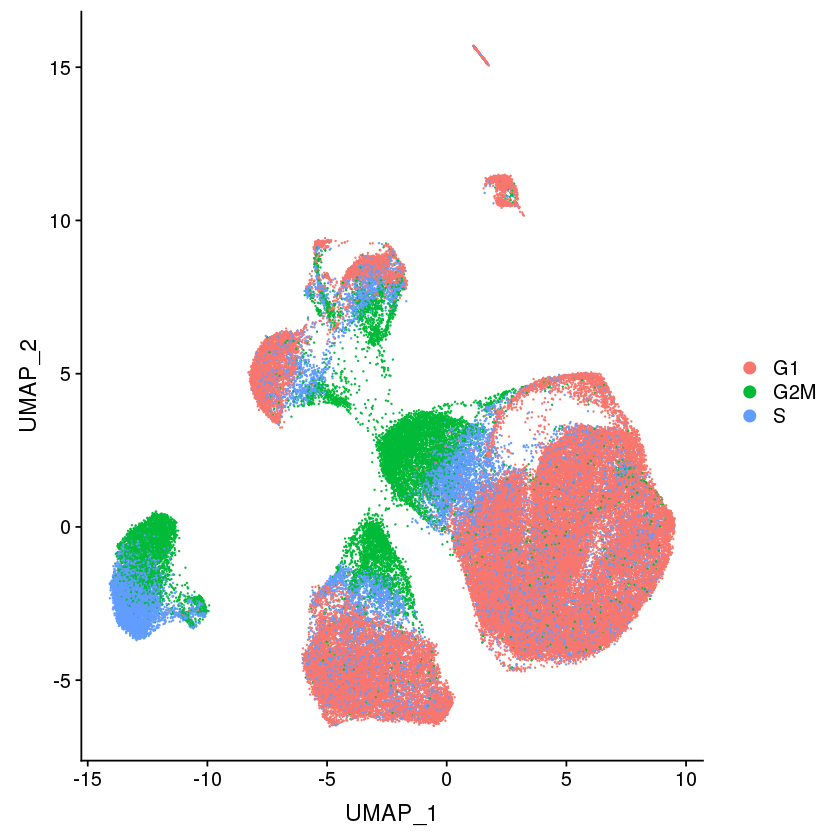

In [10]:
DimPlot(tiss, group.by = "Phase")

# Try #1: adjust for only cell cycle

In [10]:
tiss <- ScaleData(tiss, vars.to.regress = c("S.Score", "G2M.Score"))

Regressing out S.Score, G2M.Score
Centering and scaling data matrix


## Recluster

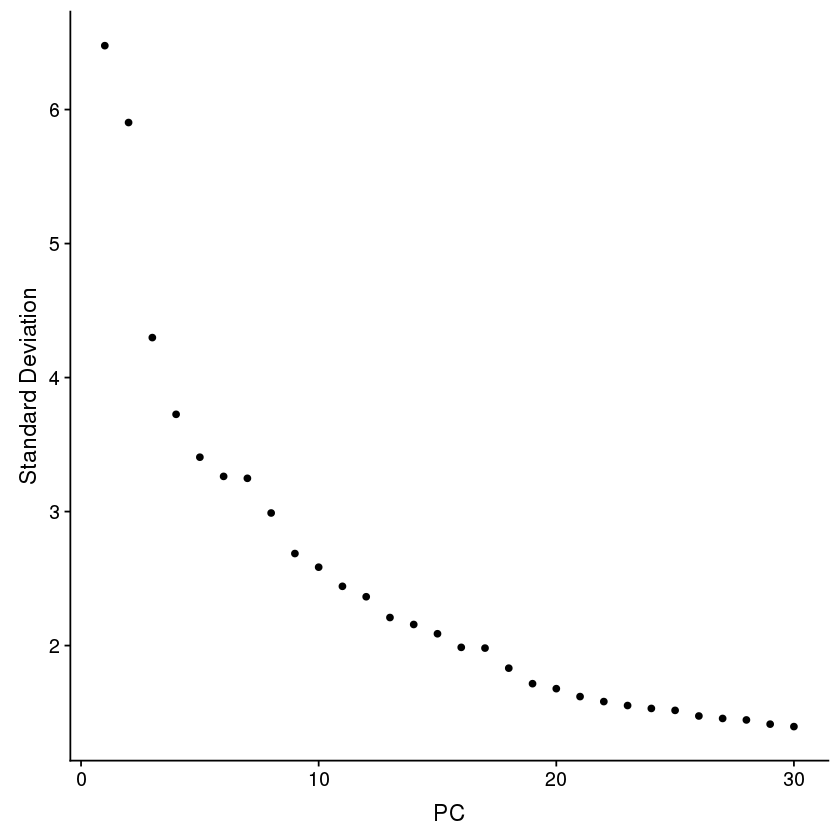

In [12]:
tiss <- RunPCA(tiss, npcs = 30, verbose = FALSE)
ElbowPlot(tiss, ndims = 30)

In [13]:
tiss <- RunUMAP(tiss, reduction = "pca", dims = 1:20)

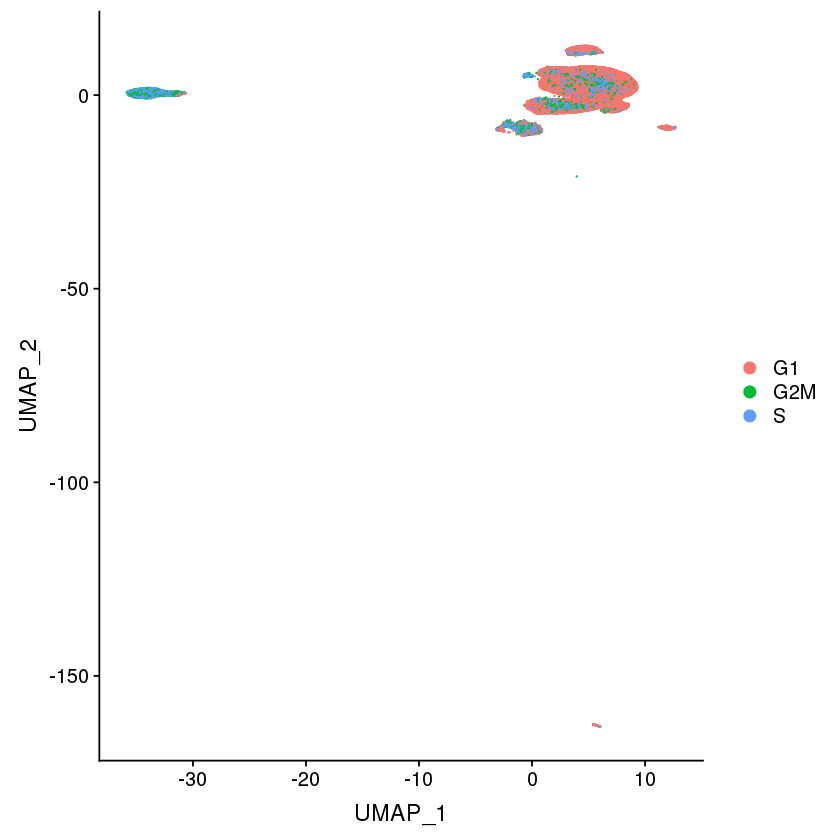

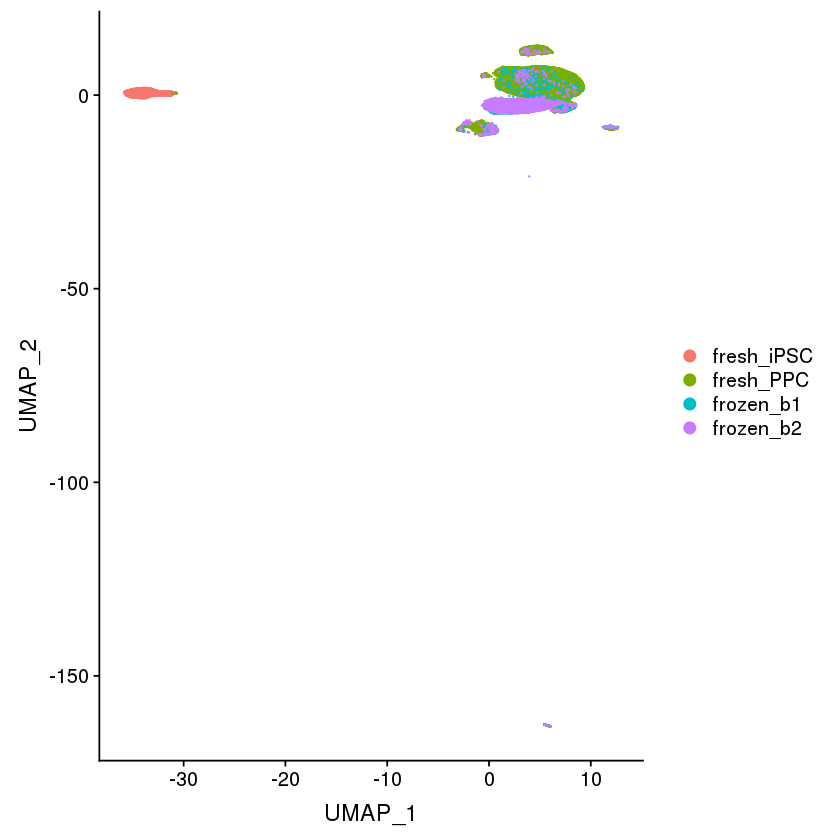

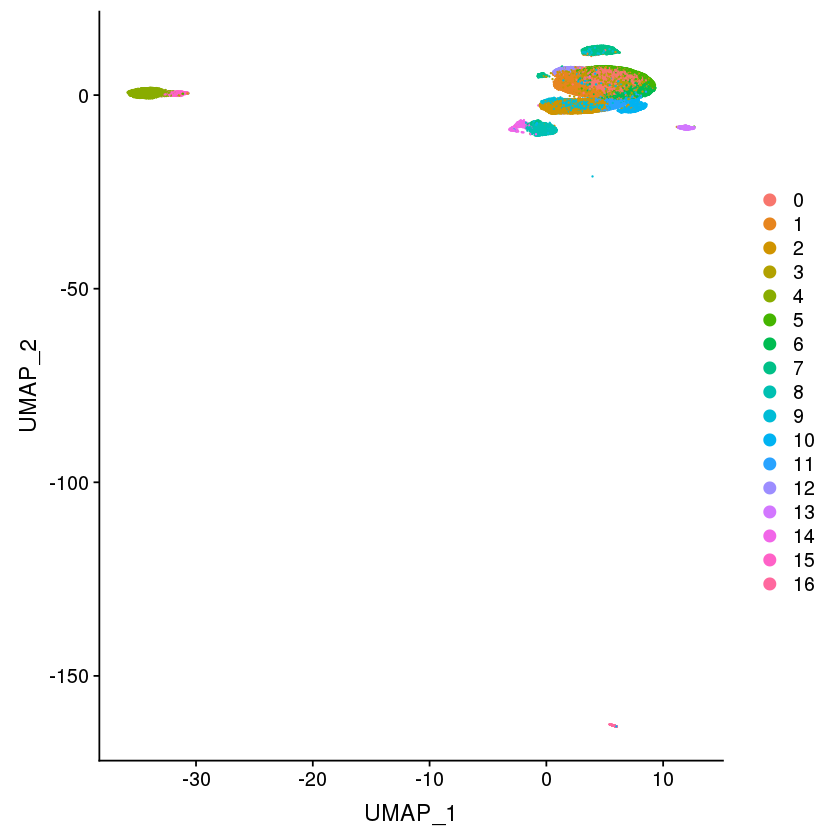

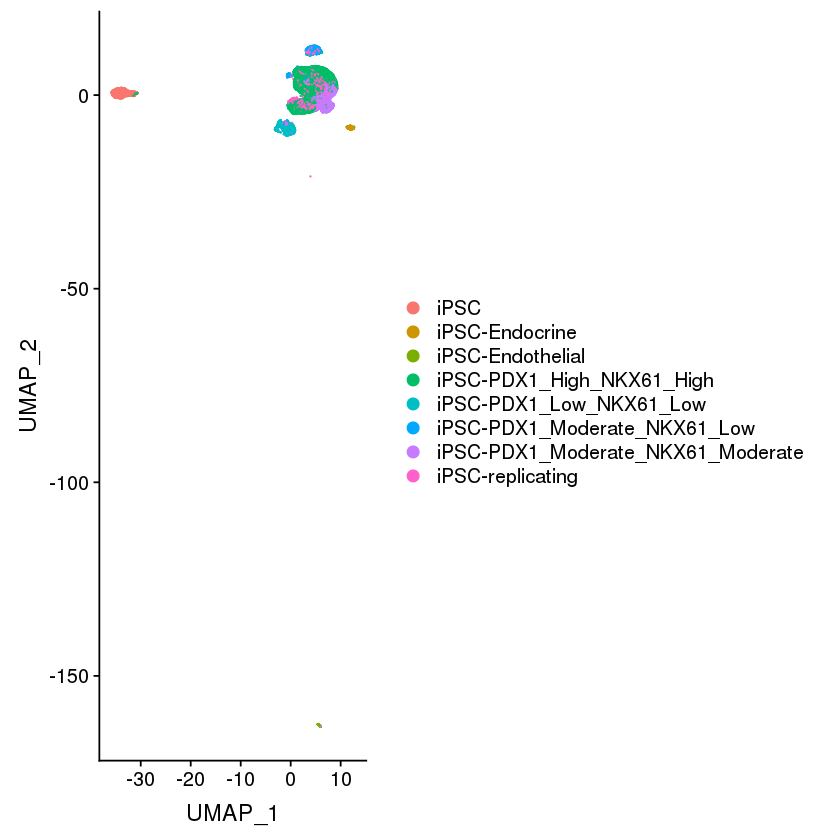

In [23]:
DimPlot(tiss, group.by = "Phase")
DimPlot(tiss, group.by = "batch")
DimPlot(tiss, group.by = "seurat_clusters")
DimPlot(tiss, group.by = "new_celltype")

## Subset - remove endothelial for visualization

In [24]:
tiss.subset = subset(tiss, idents = seq(0, 15))

In [26]:
# remove endothelial population and 2 trash cells
UMAP_get2cells = as.data.frame(Embeddings(object = tiss.subset[["umap"]]))
UMAP_get2cells2remove = rownames(UMAP_get2cells[ UMAP_get2cells$UMAP_2 < -50, ])
allcells = rownames(UMAP_get2cells)
allcellsNo2 = allcells[! allcells %in% UMAP_get2cells2remove]

In [27]:
tiss.subset = subset(tiss, cells = allcellsNo2)

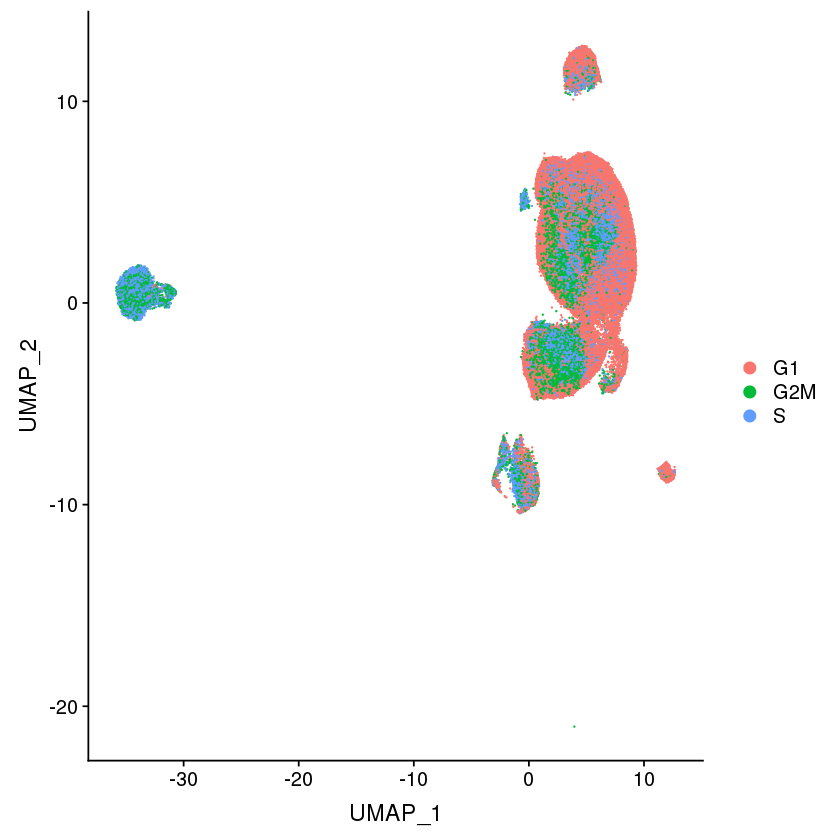

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”

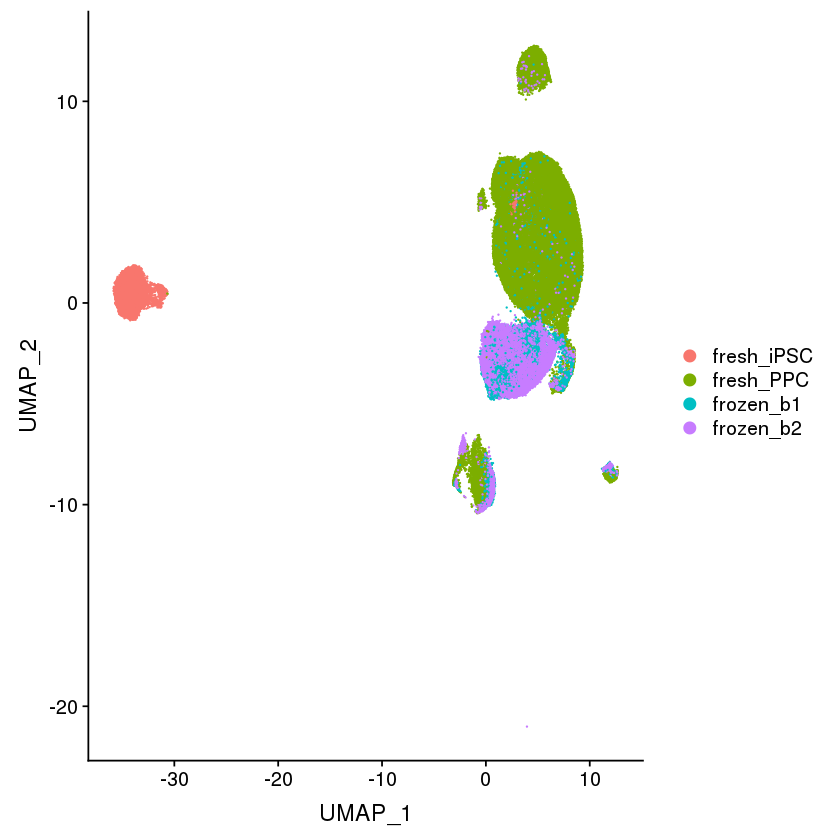

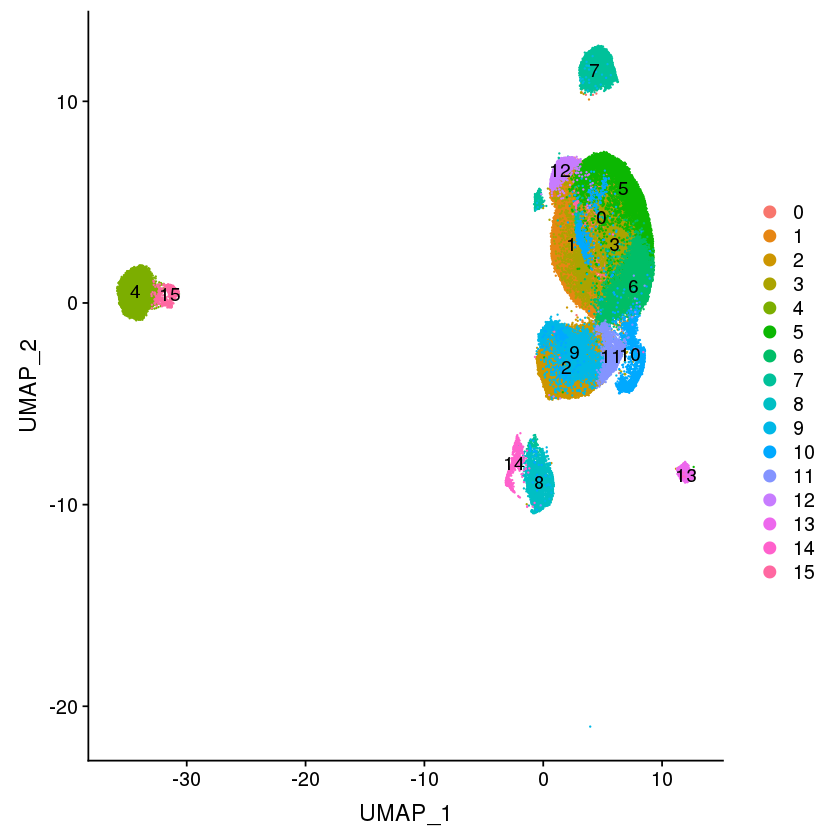

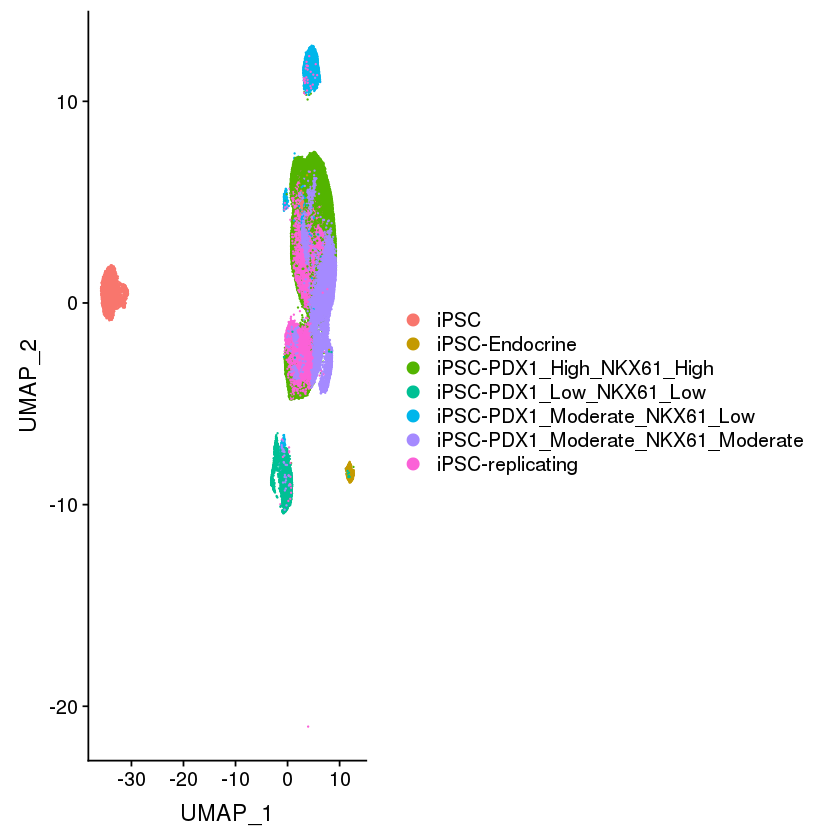

In [29]:
DimPlot(tiss.subset, group.by = "Phase")
DimPlot(tiss.subset, group.by = "batch")
DimPlot(tiss.subset, group.by = "seurat_clusters", label = T)
DimPlot(tiss.subset, group.by = "new_celltype")

In [ ]:
markers_ff <- FindMarkers(tiss, ident.1 = c(2,9), ident.2 = c(3, 0, 1, 12, 5, 6), min.pct = 0.25)

## What genes are driving fresh-frozen differences?

In [31]:
tiss.cc_ff = tiss

In [41]:
tiss.cc_ff@meta.data$batch_ff <- paste(str_split_fixed(tiss.cc_ff@meta.data$batch, "_", 2)[,1], "_", tiss.cc_ff@meta.data$seurat_clusters, sep = "")
tiss.cc_ff@meta.data[tiss.cc_ff@meta.data$batch_ff %in% c("frozen_2", "frozen_9"), "batch_ff"] = "frozen_PPC"
tiss.cc_ff@meta.data[tiss.cc_ff@meta.data$batch_ff %in% c("fresh_3", "fresh_0", "fresh_1", "fresh_12", "fresh_5", "fresh_6"), "batch_ff"] = "fresh_PPC"

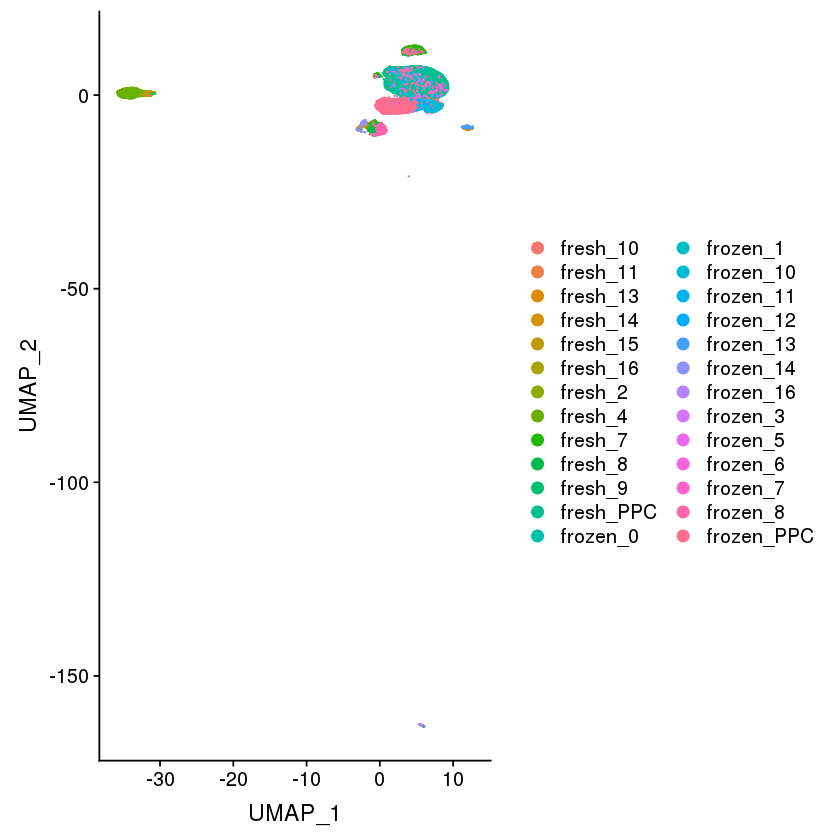

In [44]:
DimPlot(tiss.cc_ff, group.by = "batch_ff")

In [61]:
tiss.cc_ff[["percent.mt"]] <- PercentageFeatureSet(tiss.cc_ff, pattern = "^MT-")

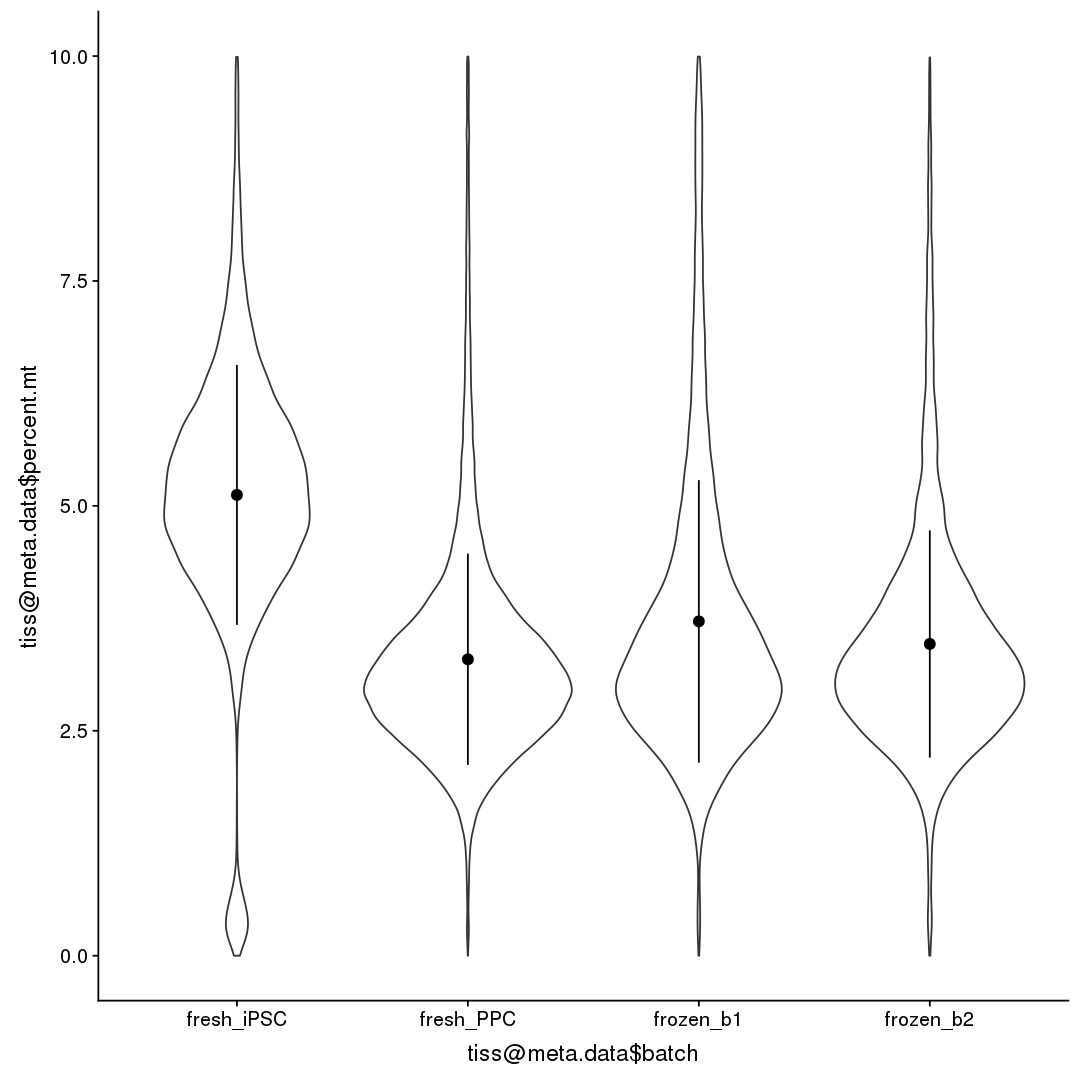

In [62]:
ggplot(tiss@meta.data, aes(x=tiss@meta.data$batch, y=tiss@meta.data$percent.mt)) + 
       geom_violin() +
       stat_summary(fun.data=data_summary)

In [47]:
markers_ff <- FindMarkers(tiss.cc_ff, ident.1 = c(2,9), ident.2 = c(3, 0, 1, 12, 5, 6), min.pct = 0.25)

In [16]:
# head(markers_ff[ markers_ff$avg_logFC > 0.1 & markers_ff$p_val_adj < 0.05, ], 100)

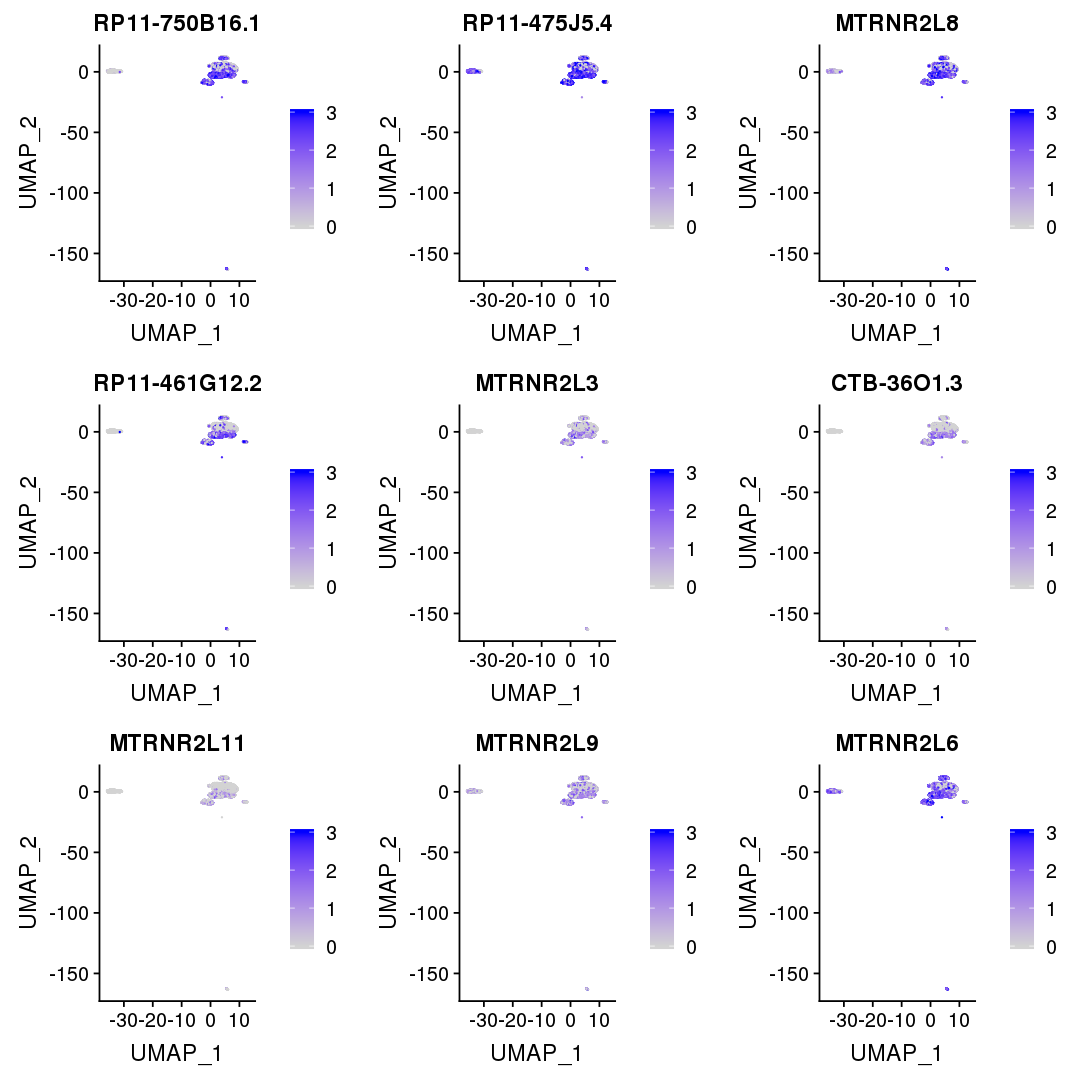

In [57]:
options(repr.plot.width = 9, repr.plot.height = 9)
FeaturePlot(tiss.cc_ff,
            rownames(markers_ff[ markers_ff$avg_logFC > 0.25 & markers_ff$p_val_adj < 0.05, ])[1:9],
            max.cutoff = 3, 
            ncol = 3)

This makes a lot of sense!
https://www.nature.com/articles/ncomms14049
"o determine the effect that a freeze-thaw might have on gene expression and thus on the ability of our scRNA-seq pipeline to classify cell type in frozen repository specimens, we froze the remaining fresh PBMCs from Donor A, and made a scRNA-seq library from gently thawed cells 3 weeks later where ∼3k cells were recovered (Supplementary Methods). The two data sets (fresh and frozen) showed a high similarity between their average gene expression (r=0.96; Supplementary Methods and Supplementary Fig. 8a). Fifty-seven genes showed twofold upregulation in the frozen sample, with ∼50% being ribosomal protein genes, and the rest not enriched in any pathways (Supplementary Table 5). In addition, the number of genes and UMI counts detected from fresh and frozen PBMCs was very similar (P=0.8 and 0.1, respectively), suggesting that the conversion efficiency of the system is not compromised when profiling frozen cells (Supplementary Fig. 8b). Furthermore, subpopulations were detected from frozen PBMCs at a similar proportion to that of fresh PBMCs, demonstrating the applicability of our method on frozen samples"

# Try #2: Regress out cell cycle AND MT AND TP genes

In [30]:
tiss[["percent.mt"]] <- PercentageFeatureSet(tiss, pattern = "^MT")
tiss[["percent.rp"]] <- PercentageFeatureSet(tiss, pattern = "^RP")

In [31]:
tiss <- ScaleData(tiss, vars.to.regress = c("S.Score", "G2M.Score", "percent.mt", "percent.rp"))

Regressing out S.Score, G2M.Score, percent.mt, percent.rp
Centering and scaling data matrix


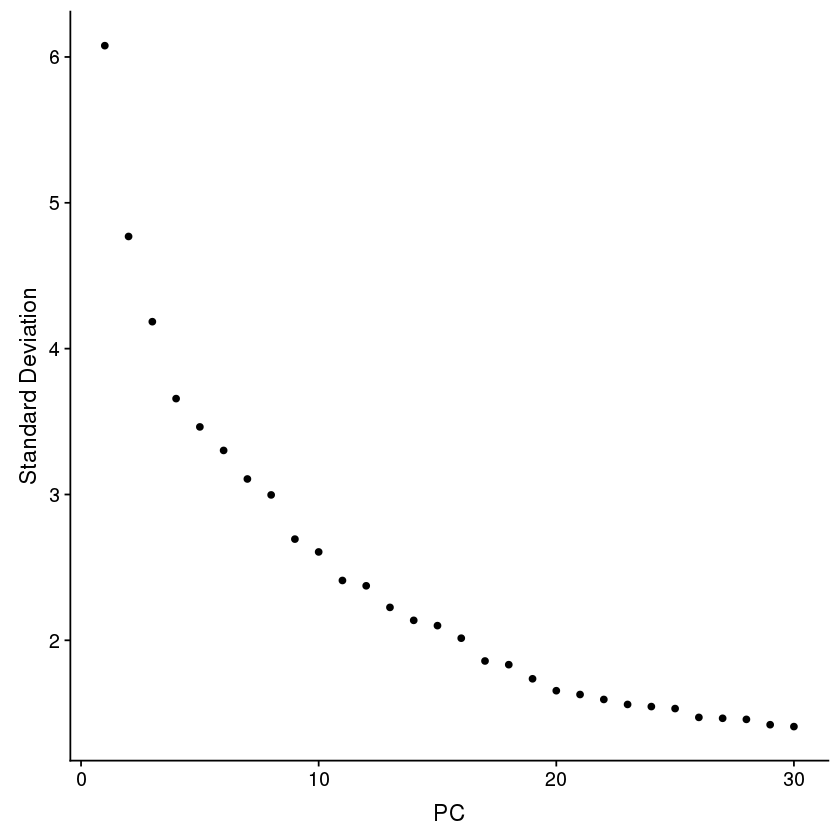

In [32]:
tiss <- RunPCA(tiss, npcs = 30, verbose = FALSE)
ElbowPlot(tiss, ndims = 30)

In [33]:
tiss <- RunUMAP(tiss, reduction = "pca", dims = 1:20)

Warning message:
“Removed 8453 rows containing missing values (geom_point).”

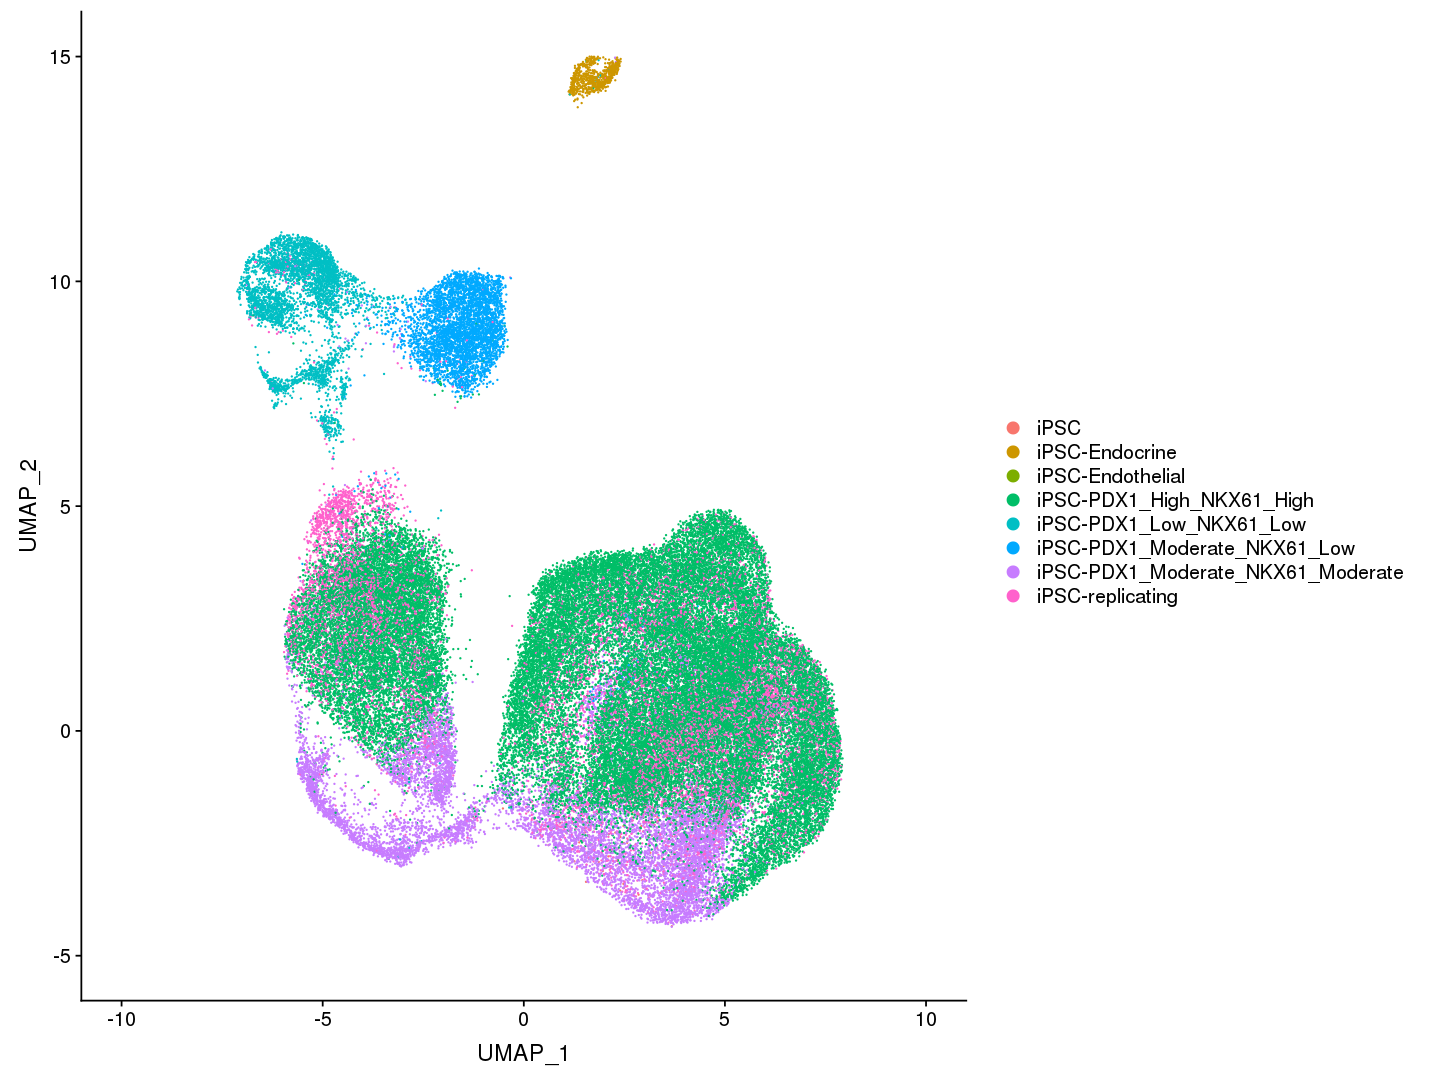

In [44]:
# options(repr.plot.width = 9, repr.plot.height = 9)
# DimPlot(tiss, group.by = "Phase") + xlim(c(-10, 10)) + ylim(c(-5, 15))
# DimPlot(tiss, group.by = "batch")+ xlim(c(-10, 10)) + ylim(c(-5, 15))
# DimPlot(tiss, group.by = "seurat_clusters", label = T) + NoLegend()+ xlim(c(-10, 10)) + ylim(c(-5, 15))
options(repr.plot.width = 12, repr.plot.height = 9)
DimPlot(tiss, group.by = "new_celltype")+ xlim(c(-10, 10)) + ylim(c(-5, 15))

# Try #3: Adjust for DE genes between fresh and frozen

In [11]:
tiss@meta.data$batch_ff <- paste(str_split_fixed(tiss@meta.data$batch, "_", 2)[,1], "_", tiss@meta.data$seurat_clusters, sep = "")
tiss@meta.data[tiss@meta.data$batch_ff %in% c("frozen_2", "frozen_9"), "batch_ff"] = "frozen_PPC"
tiss@meta.data[tiss@meta.data$batch_ff %in% c("fresh_3", "fresh_0", "fresh_1", "fresh_12", "fresh_5", "fresh_6"), "batch_ff"] = "fresh_PPC"

In [12]:
markers_ff <- FindMarkers(tiss, ident.1 = c(2,9), ident.2 = c(3, 0, 1, 12, 5, 6), min.pct = 0.25)

In [13]:
ff_de_genes = rownames(markers_ff[ markers_ff$avg_logFC > 0.3 & markers_ff$p_val_adj < 0.05, ])

In [15]:
# write.table(markers_ff[ markers_ff$avg_logFC > 0.3 & markers_ff$p_val_adj < 0.05, ], file = "../Table/ff.degenes4correction.txt")

In [65]:
tiss[["percent.ff"]] <- PercentageFeatureSet(tiss, features = ff_de_genes)

In [66]:
tiss <- ScaleData(tiss, vars.to.regress = c("S.Score", "G2M.Score", "percent.ff"))

Regressing out S.Score, G2M.Score, percent.ff
Centering and scaling data matrix


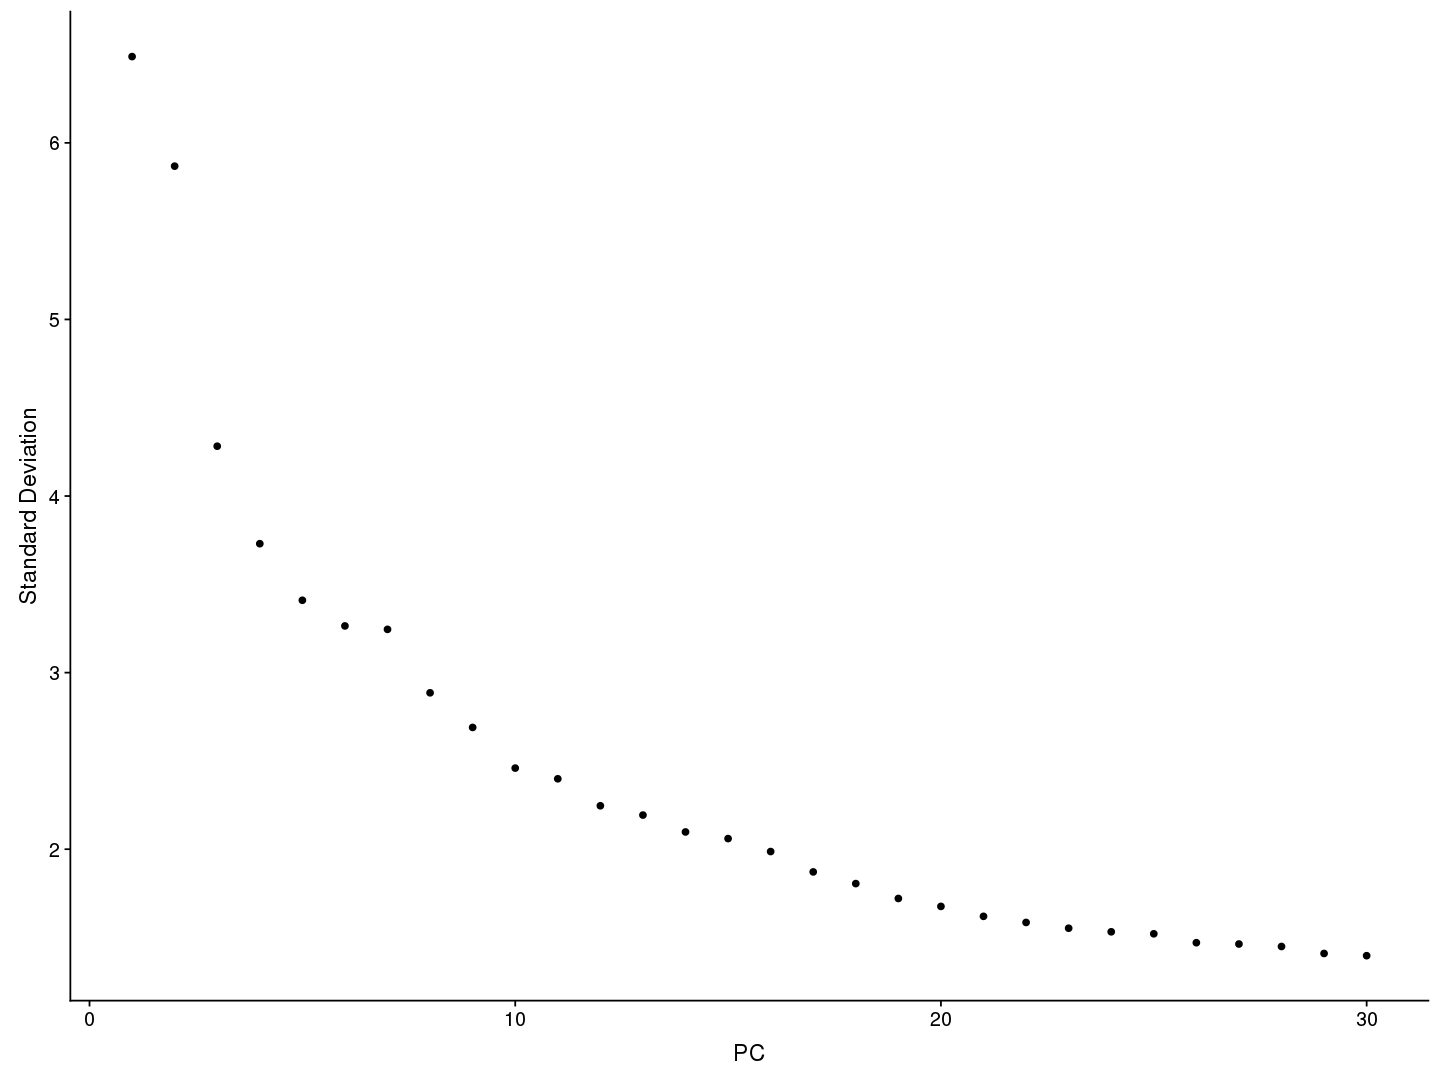

In [67]:
tiss <- RunPCA(tiss, npcs = 30, verbose = FALSE)
ElbowPlot(tiss, ndims = 30)

In [68]:
tiss <- RunUMAP(tiss, reduction = "pca", dims = 1:20)

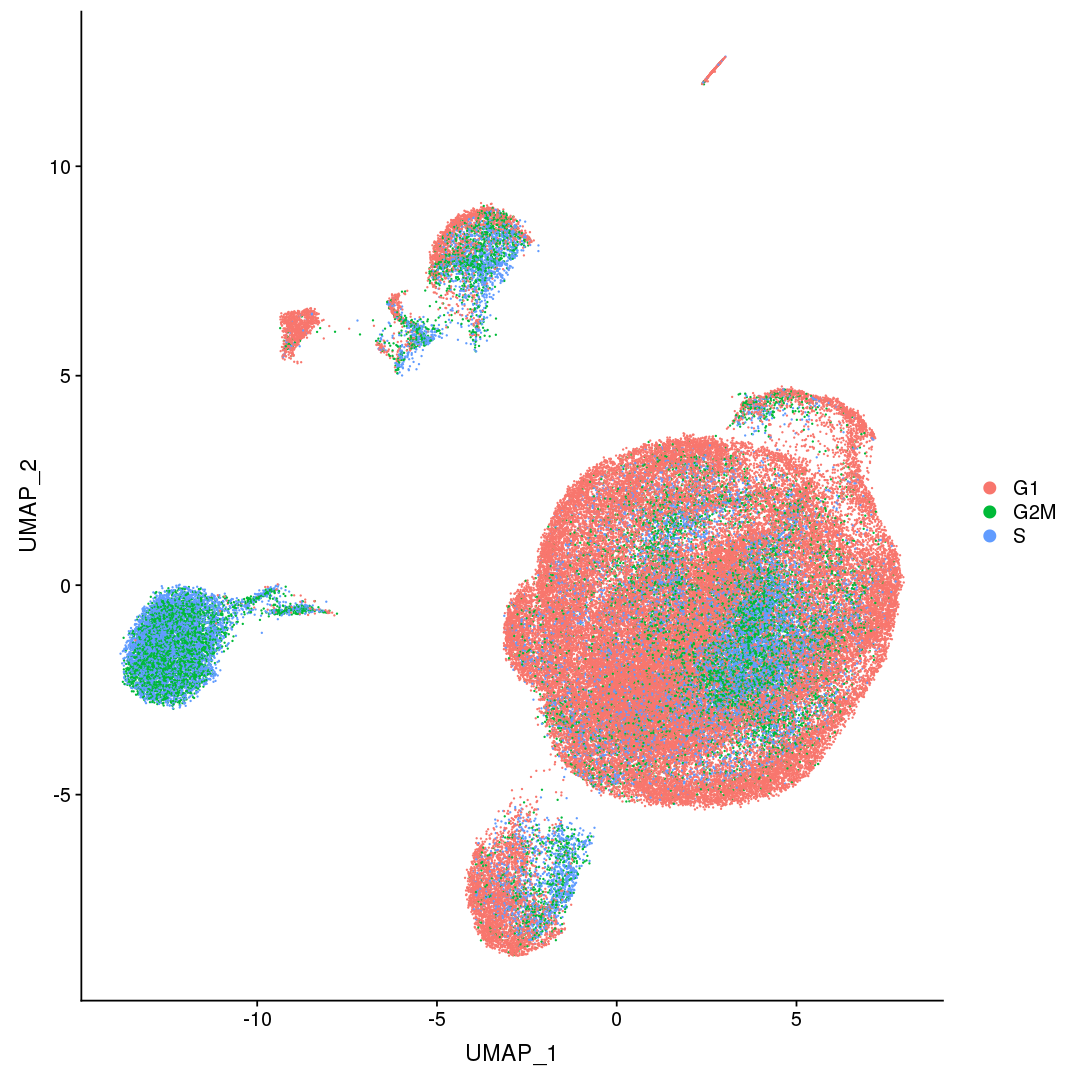

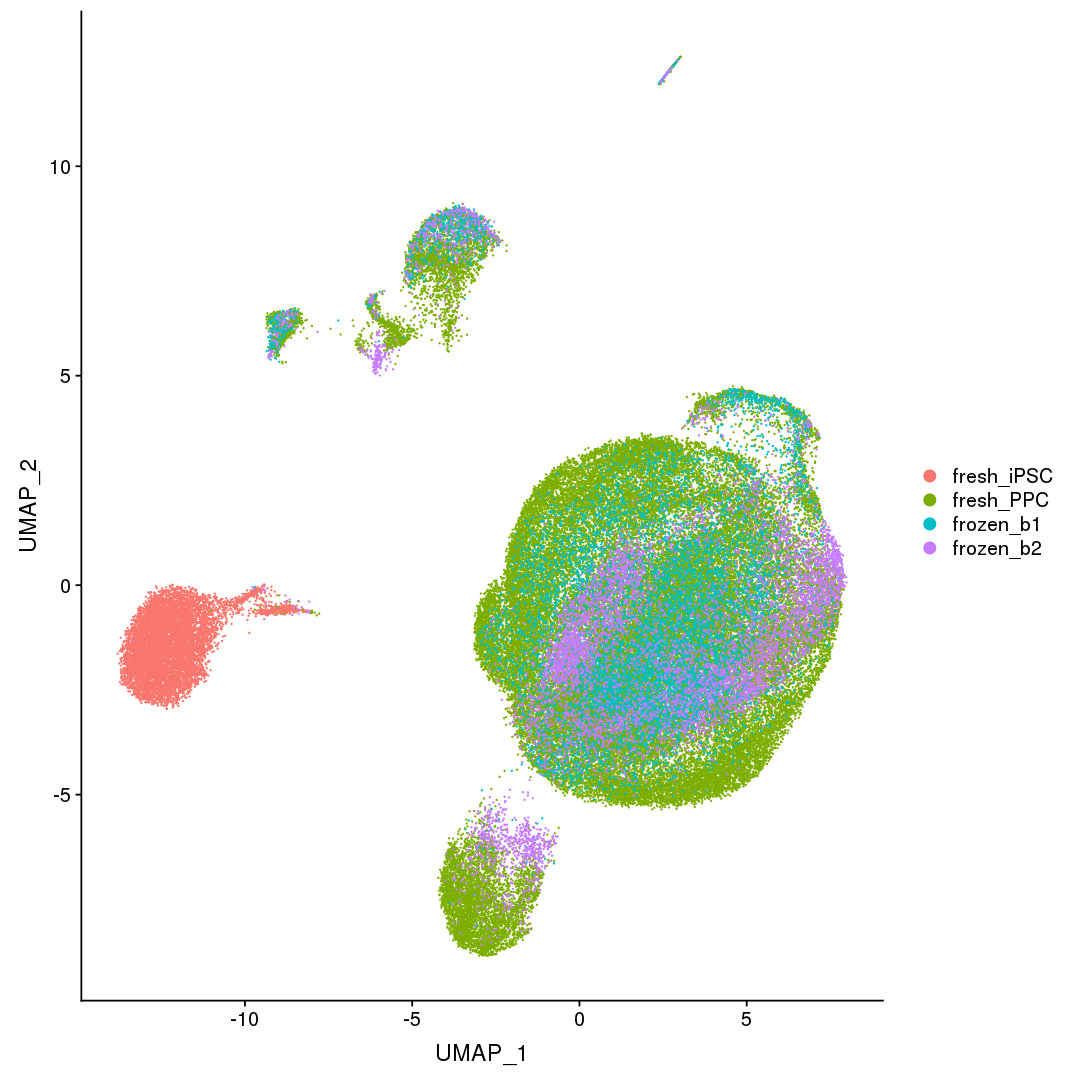

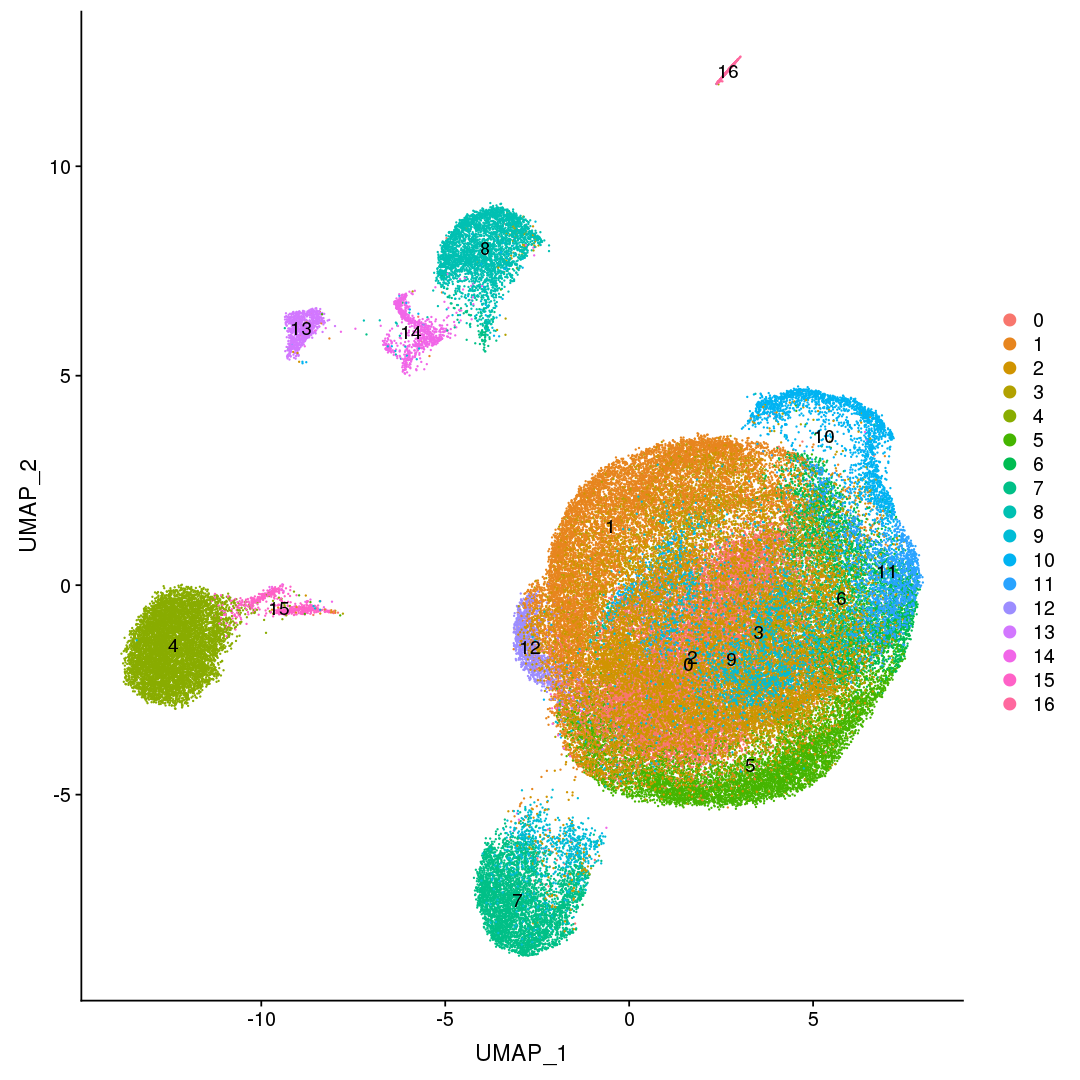

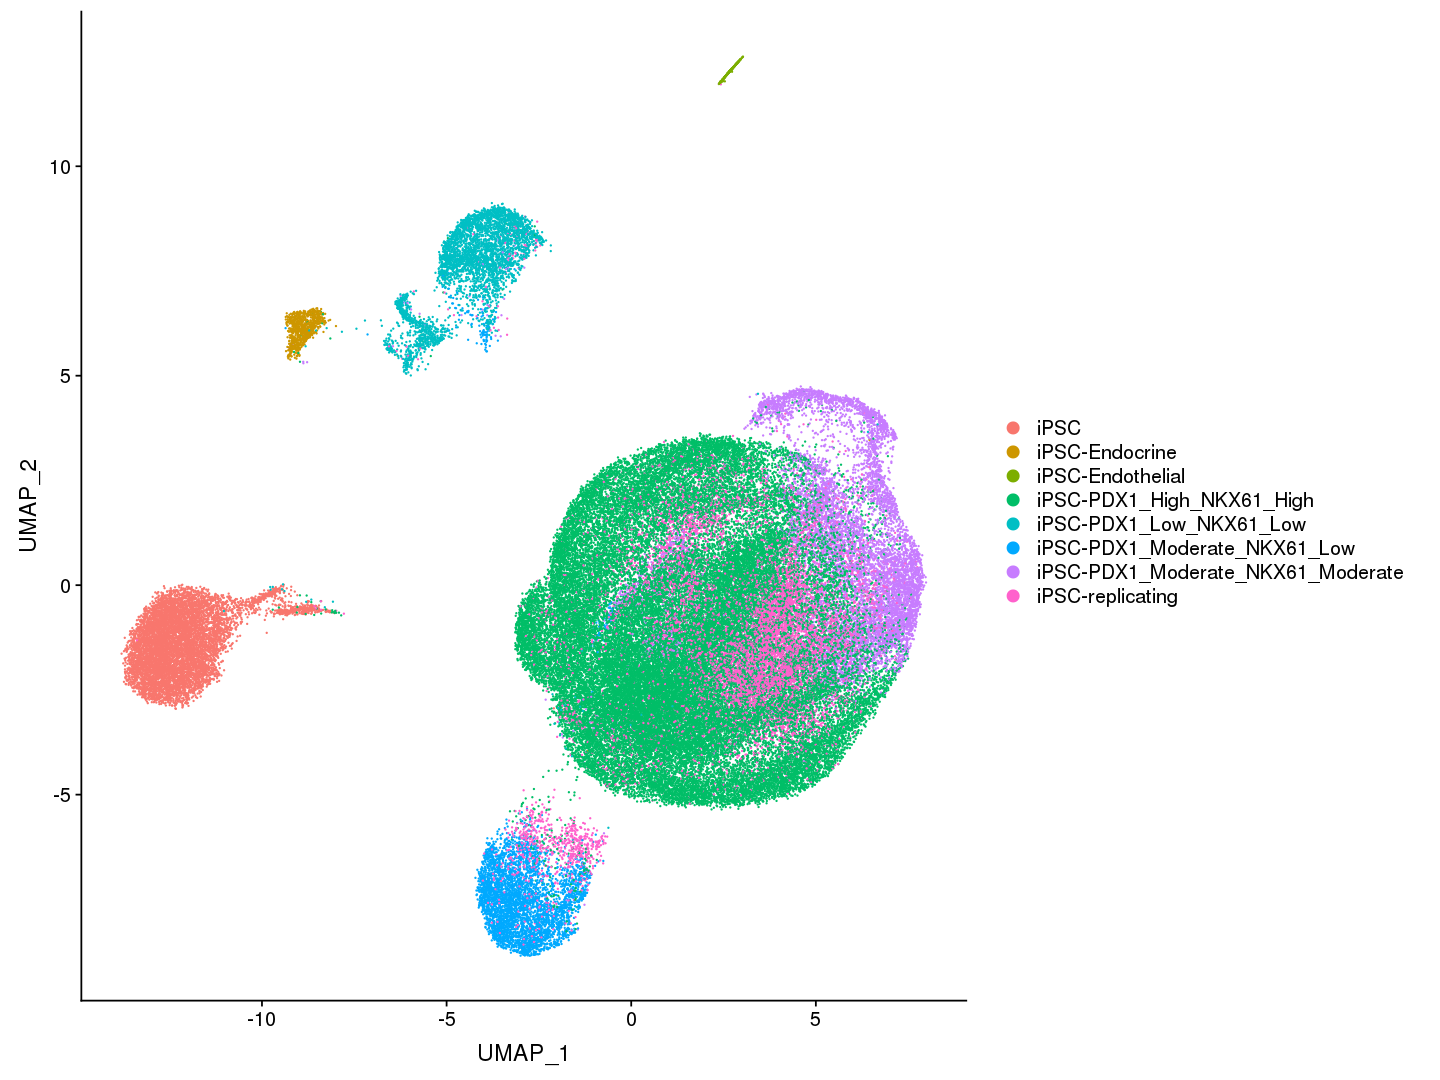

In [69]:
options(repr.plot.width = 9, repr.plot.height = 9)
DimPlot(tiss, group.by = "Phase") #+ xlim(c(-10, 10)) + ylim(c(-5, 15))
DimPlot(tiss, group.by = "batch") #+ xlim(c(-10, 10)) + ylim(c(-5, 15))
DimPlot(tiss, group.by = "seurat_clusters", label = T) #+ NoLegend()+ xlim(c(-10, 10)) + ylim(c(-5, 15))
options(repr.plot.width = 12, repr.plot.height = 9)
DimPlot(tiss, group.by = "new_celltype") #+ xlim(c(-10, 10)) + ylim(c(-5, 15))

In [226]:
tiss@meta.data$celltype = str_split_fixed(tiss@meta.data$sample_name, "_", 2)[,1]
tiss@meta.data$ff       = str_split_fixed(tiss@meta.data$batch, "_", 2)[,1]
tiss@meta.data$udid     = tiss@meta.data$sample_name

tiss@meta.data[tiss@meta.data$udid == "iPSC_fresh", "udid"] = "iPSC_fresh_PPC_034"
tiss@meta.data[tiss@meta.data$udid == "PPC_frozen_b1", "udid"] = tiss@meta.data[tiss@meta.data$udid == "PPC_frozen_b1", "subject"]
tiss@meta.data[tiss@meta.data$udid == "PPC_frozen_b2", "udid"] = tiss@meta.data[tiss@meta.data$udid == "PPC_frozen_b2", "subject"]

tiss@meta.data$udid = str_split_fixed(tiss@meta.data$udid, "_", 3)[, 3]
tiss@meta.data[tiss@meta.data$udid == "b1_C0005", "udid"]  = "PPC_027"
tiss@meta.data[tiss@meta.data$udid == "b1_Q0115", "udid"]  = "PPC_023"
tiss@meta.data[tiss@meta.data$udid == "b1_T104", "udid"]   = "PPC_034"
tiss@meta.data[tiss@meta.data$udid == "b1_T600", "udid"]   = "PPC_029"
tiss@meta.data[tiss@meta.data$udid == "b2_P0353", "udid"]  = "PPC_150"
tiss@meta.data[tiss@meta.data$udid == "b2_S02307", "udid"] = "PPC_134"
tiss@meta.data[tiss@meta.data$udid == "b2_T151", "udid"]   = "PPC_051"


tiss@meta.data$cell_ff_sample <- paste(tiss@meta.data$celltype, tiss@meta.data$ff, tiss@meta.data$udid, sep = "_")

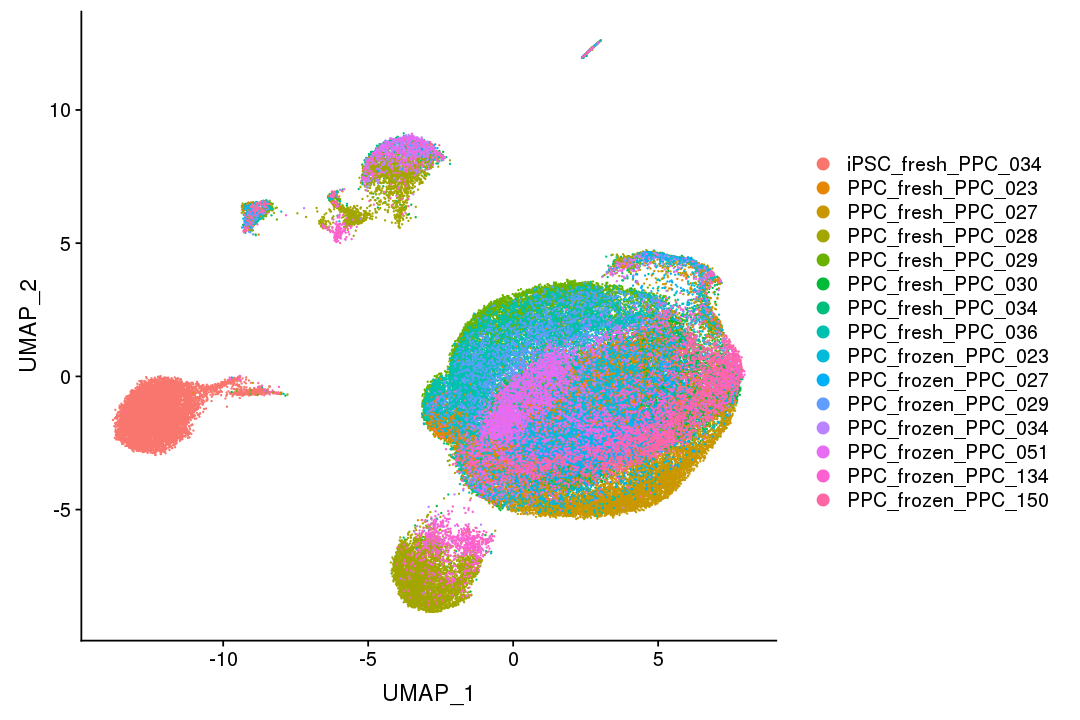

In [227]:
options(repr.plot.width = 9, repr.plot.height = 6)

DimPlot(tiss, group.by = "cell_ff_sample")

# Calculate pseudotime

In [83]:
library(SCORPIUS)

totime = Embeddings(object = tiss, reduction = "pca")

exp = GetAssayData(object = tiss, slot = "scale.data")

space = reduce_dimensionality(as.matrix(totime), "spearman", ndim = 3)

traj = infer_trajectory(space)

cell2time = data.frame(cell = names(traj$time), time = as.numeric(traj$time))



In [228]:
tiss@meta.data$cell = rownames(tiss@meta.data)

cell2time.new = merge(cell2time, tiss@meta.data, by = "cell")

genes = c("PDX1", "NKX6-1", "CHGA")
genes.exp = as.data.frame(t(exp[genes, ]))
genes.exp$cell = rownames(genes.exp)

cell2time.new = merge(cell2time.new, genes.exp, by = "cell")
colnames(cell2time.new) = gsub("-", "_", colnames(cell2time.new))



In [250]:
# write.table(cell2time.new, file = "../Table/frazer_scorpius_time.txt")

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


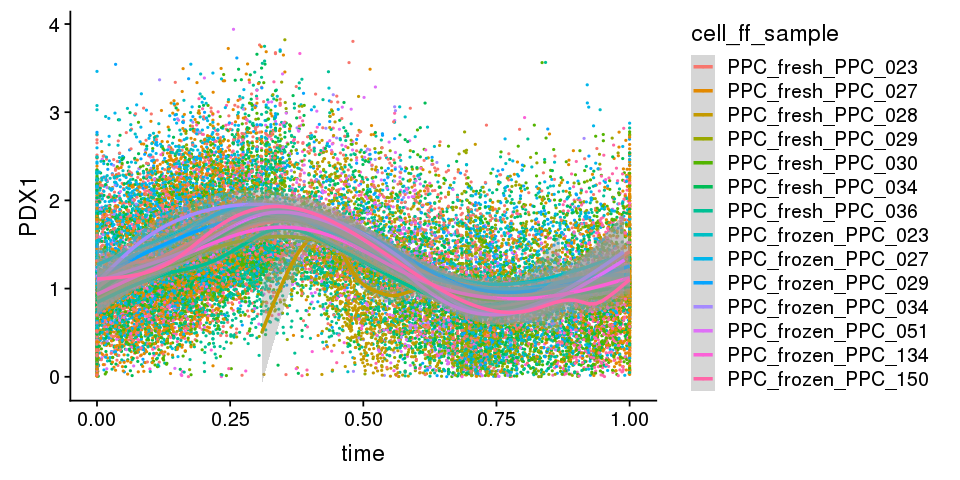

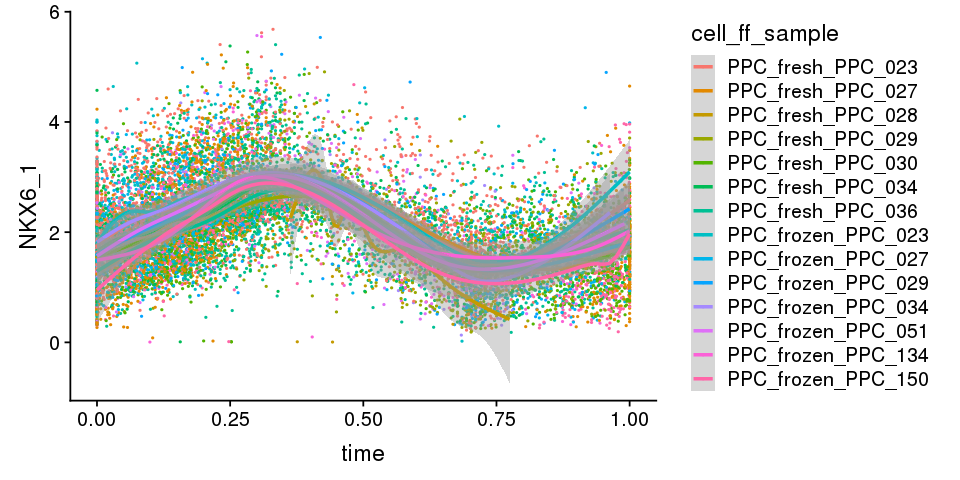

In [229]:
options(repr.plot.width = 8, repr.plot.height = 4)

ggplot(cell2time.new[!cell2time.new$batch == "fresh_iPSC" & cell2time.new$PDX1 > 0, ], aes(x=time, y=PDX1, color=cell_ff_sample)) +
  geom_point(size=.25) +
  geom_smooth()

ggplot(cell2time.new[!cell2time.new$batch == "fresh_iPSC" & cell2time.new$NKX6_1 > 0, ], aes(x=time, y=NKX6_1, color=cell_ff_sample)) +
  geom_point(size=.25) +
  geom_smooth()

# ggplot(cell2time.new, aes(x=time, y=CHGA, color=cell_ff_sample)) +
#   geom_point(size=.25) +
#   geom_smooth()


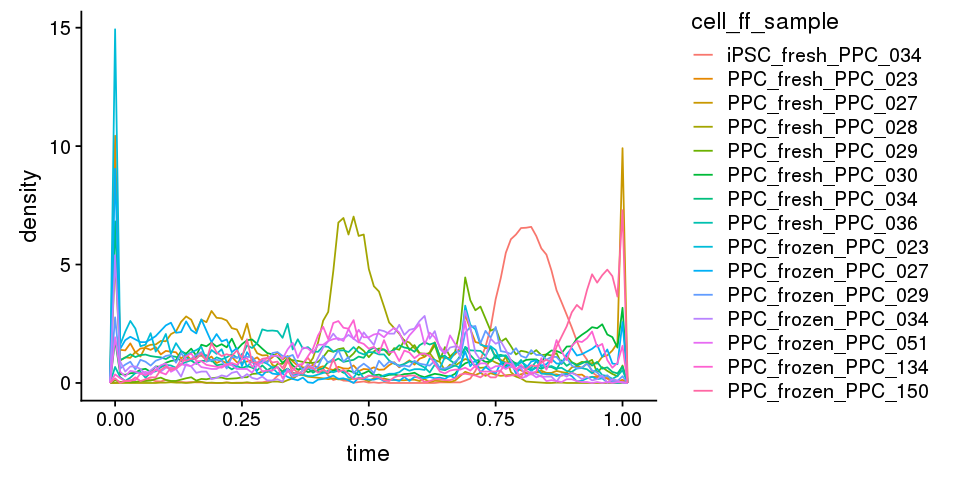

In [246]:
options(repr.plot.width = 8, repr.plot.height = 4)

ggplot(cell2time.new, aes(x=time, stat(density), colour=cell_ff_sample)) +
       geom_freqpoly(binwidth = 0.01)


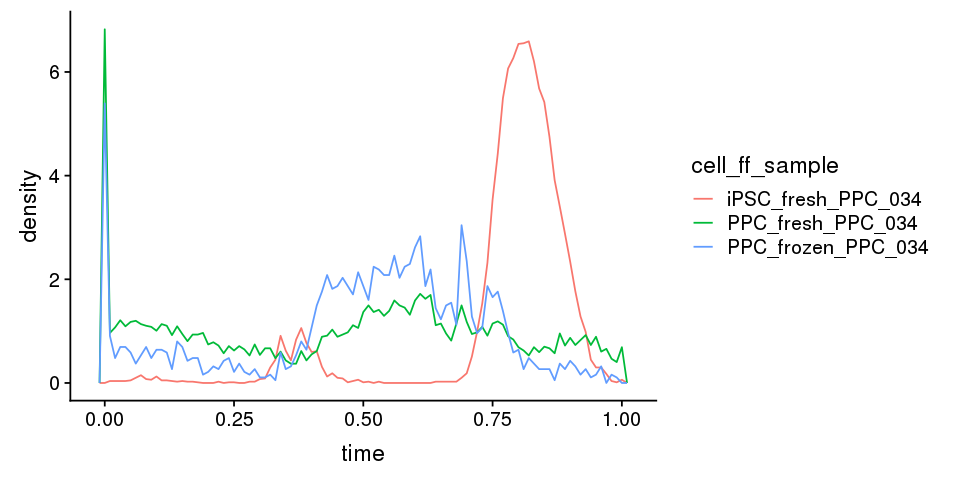

In [243]:
ggplot(cell2time.new[ cell2time.new$udid == "PPC_034", ], aes(x=time, stat(density), colour=cell_ff_sample)) +
       geom_freqpoly(binwidth = 0.01)

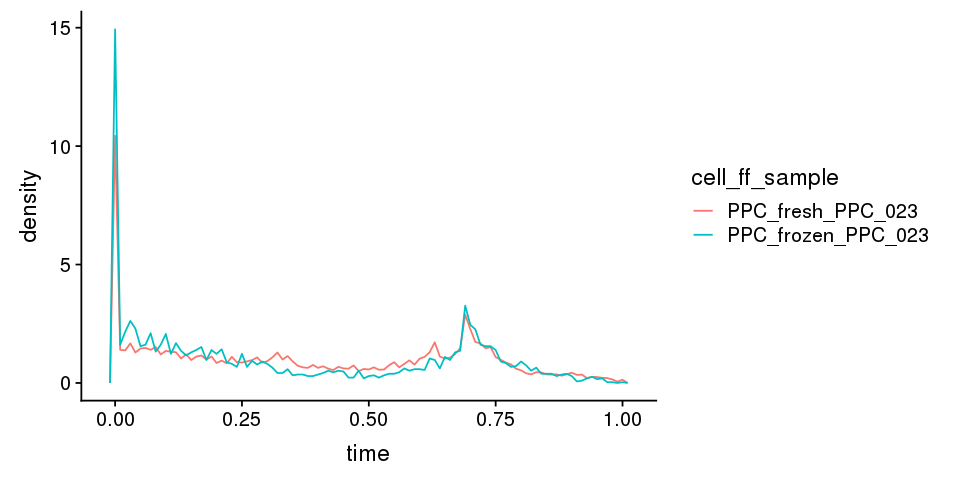

In [242]:
ggplot(cell2time.new[ cell2time.new$udid == "PPC_023", ], aes(x=time, stat(density), colour=cell_ff_sample)) +
       geom_freqpoly(binwidth = 0.01)


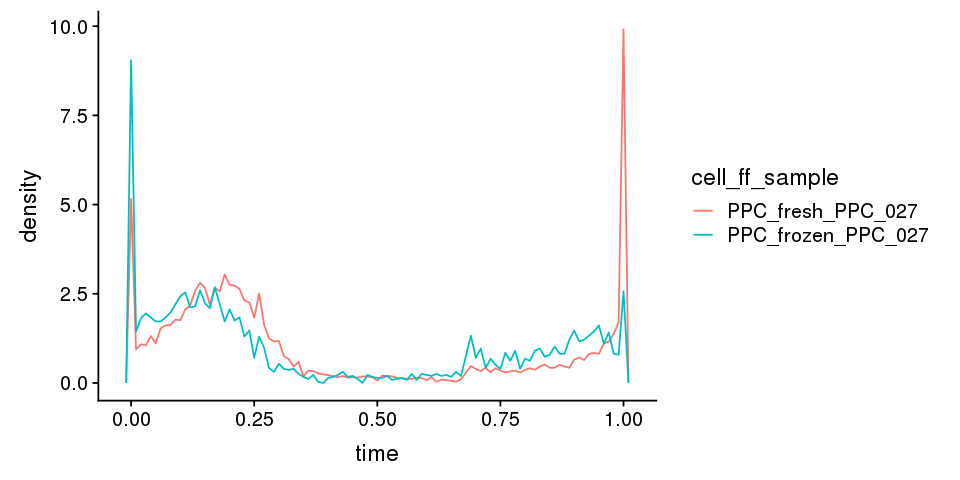

In [244]:
ggplot(cell2time.new[ cell2time.new$udid == "PPC_027", ], aes(x=time, stat(density), colour=cell_ff_sample)) +
       geom_freqpoly(binwidth = 0.01)

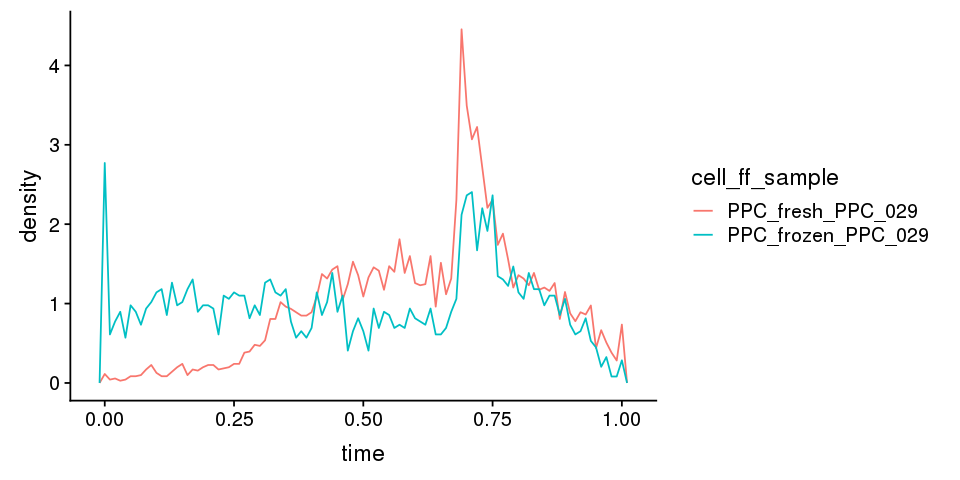

In [245]:
ggplot(cell2time.new[ cell2time.new$udid == "PPC_029", ], aes(x=time, stat(density), colour=cell_ff_sample)) +
       geom_freqpoly(binwidth = 0.01)

In [247]:
save(tiss, file = "../data/frazer_cc_ff_adjusted.robj")

# Integrate with melton

Try 3 ways:

1. Frazer.adjusted + melton
2. Frazer.adjusted + melton.adjusted
3. Frazer + melton -> adjust after integration

In [2]:
library(Seurat)

In [168]:
load("../data/frazer_cc_ff_adjusted.robj")
frazer_tiss = tiss

In [169]:
tiss = NULL

In [170]:
frazer_tiss@meta.data$Celltype <- frazer_tiss@meta.data$cell_ff_sample
frazer_tiss@meta.data$set      <- frazer_tiss@meta.data$batch

In [171]:
#### load melvin data #####
load("/projects/PPC/analysis/ppc_pilot/data/old/melvin_data/Stages_3_to_6.x1_S3c.Robj")
S3c = tiss
load("/projects/PPC/analysis/ppc_pilot/data/old/melvin_data/Stages_3_to_6.x1_S4c.Robj")
S4c = tiss
load("/projects/PPC/analysis/ppc_pilot/data/old/melvin_data/Stages_3_to_6.x1_S5c.Robj")
S5c = tiss
load("/projects/PPC/analysis/ppc_pilot/data/old/melvin_data/Stages_3_to_6.x1_S6c.Robj")
S6c = tiss
# load("/projects/PPC/analysis/ppc_pilot/data/old/melvin_data/ESB_only_integrated.Robj")
# scb_integrated = integrated

S3c@meta.data$Celltype <- S3c@meta.data$Assigned_cluster
S4c@meta.data$Celltype <- S4c@meta.data$Assigned_cluster
S5c@meta.data$Celltype <- S5c@meta.data$Assigned_cluster
S6c@meta.data$Celltype <- S6c@meta.data$Assigned_cluster
S3c@meta.data$set    <- S3c@meta.data$Lib_prep_batch
S4c@meta.data$set    <- S4c@meta.data$Lib_prep_batch
S5c@meta.data$set    <- S5c@meta.data$Lib_prep_batch
S6c@meta.data$set    <- S6c@meta.data$Lib_prep_batch
###########################

## Try #1: Frazer.adjusted + melton

In [188]:
data2integrate = list()
data2integrate[["frazer_tiss"]]   = frazer_tiss
data2integrate[["S3c"]]    = S3c
data2integrate[["S4c"]]    = S4c
data2integrate[["S5c"]]    = S5c
data2integrate[["S6c"]]    = S6c

In [ ]:
# if we updated to Seurat 3.1, we should be able to select reference-- should be faster? more accurate?
anchors    <- FindIntegrationAnchors(object.list = data2integrate, dims = 1:30, scale = FALSE)

Computing 2000 integration features
Finding all pairwise anchors
Running CCA
Merging objects
Finding neighborhoods


In [ ]:
integrated <- IntegrateData(anchorset = anchors, dims = 1:30)

In [ ]:
DefaultAssay(integrated) <- "integrated"

integrated <- ScaleData(integrated, verbose = FALSE)
integrated <- RunPCA(   integrated, npcs = 30, verbose = FALSE)
integrated <- RunUMAP(  integrated, reduction = "pca", dims = 1:30, seed = 10, min.dist = 0.1, n.neighbors = 30)

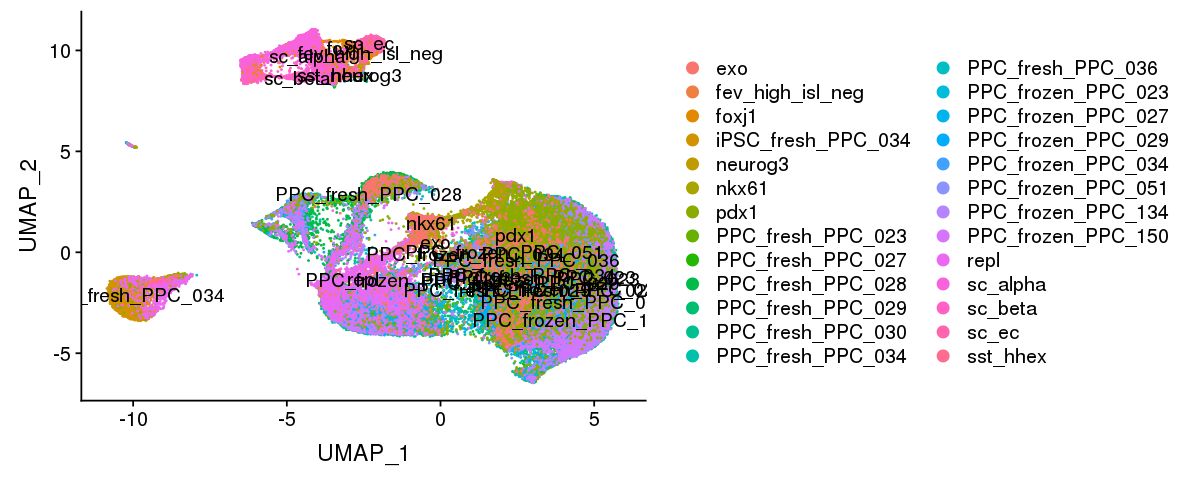

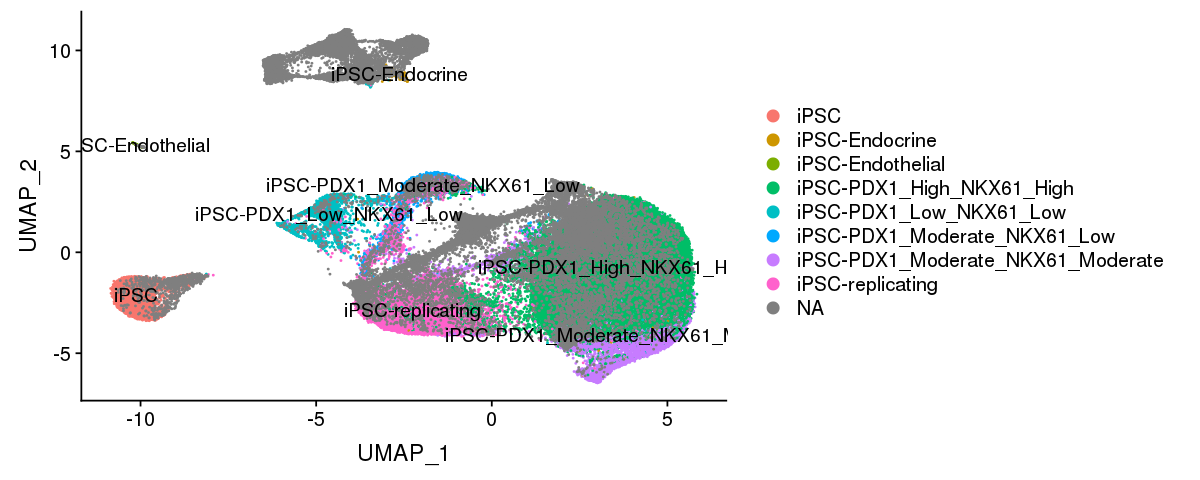

In [203]:
options(repr.plot.width = 10, repr.plot.height = 4)
DimPlot(integrated, group.by = "Celltype", label = T, pt.size = .15) #+ ylim(c(-10, 10))
DimPlot(integrated, group.by = "new_celltype", label = T, pt.size = .15) #+ ylim(c(-10, 10))

In [ ]:
save(integrated, file = "../data/frazer.cc.ff_melton_integrated_scaleF.robj")

In [195]:
integrated

An object of class Seurat 
60358 features across 108766 samples within 2 assays 
Active assay: integrated (2000 features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [204]:
integrated = NULL

## Try #2: Frazer.adjusted + melton.adjusted

In [ ]:
# #### load melvin data #####
# load("/projects/PPC/analysis/ppc_pilot/data/old/melvin_data/Stages_3_to_6.x1_S3c.Robj")
# S3c = tiss
# load("/projects/PPC/analysis/ppc_pilot/data/old/melvin_data/Stages_3_to_6.x1_S4c.Robj")
# S4c = tiss
# load("/projects/PPC/analysis/ppc_pilot/data/old/melvin_data/Stages_3_to_6.x1_S5c.Robj")
# S5c = tiss
# load("/projects/PPC/analysis/ppc_pilot/data/old/melvin_data/Stages_3_to_6.x1_S6c.Robj")
# S6c = tiss
# # load("/projects/PPC/analysis/ppc_pilot/data/old/melvin_data/ESB_only_integrated.Robj")
# # scb_integrated = integrated

# S3c@meta.data$Celltype <- S3c@meta.data$Assigned_cluster
# S4c@meta.data$Celltype <- S4c@meta.data$Assigned_cluster
# S5c@meta.data$Celltype <- S5c@meta.data$Assigned_cluster
# S6c@meta.data$Celltype <- S6c@meta.data$Assigned_cluster
# S3c@meta.data$set    <- S3c@meta.data$Lib_prep_batch
# S4c@meta.data$set    <- S4c@meta.data$Lib_prep_batch
# S5c@meta.data$set    <- S5c@meta.data$Lib_prep_batch
# S6c@meta.data$set    <- S6c@meta.data$Lib_prep_batch
# ###########################

# s.genes <- cc.genes$s.genes
# g2m.genes <- cc.genes$g2m.genes

# S3c <- CellCycleScoring(S3c, s.features = s.genes, g2m.features = g2m.genes, set.ident = FALSE)
# S4c <- CellCycleScoring(S4c, s.features = s.genes, g2m.features = g2m.genes, set.ident = FALSE)
# S5c <- CellCycleScoring(S5c, s.features = s.genes, g2m.features = g2m.genes, set.ident = FALSE)
# S6c <- CellCycleScoring(S6c, s.features = s.genes, g2m.features = g2m.genes, set.ident = FALSE)

# markers_ff = read.table("../Table/ff.degenes4correction.txt")
# ff_de_genes = rownames(markers_ff)

# S3c[["percent.ff"]] <- PercentageFeatureSet(S3c, features = ff_de_genes[ff_de_genes %in% rownames(GetAssayData(object = S3c, slot = "counts"))])
# S4c[["percent.ff"]] <- PercentageFeatureSet(S4c, features = ff_de_genes[ff_de_genes %in% rownames(GetAssayData(object = S4c, slot = "counts"))])
# S5c[["percent.ff"]] <- PercentageFeatureSet(S5c, features = ff_de_genes[ff_de_genes %in% rownames(GetAssayData(object = S5c, slot = "counts"))])
# S6c[["percent.ff"]] <- PercentageFeatureSet(S6c, features = ff_de_genes[ff_de_genes %in% rownames(GetAssayData(object = S6c, slot = "counts"))])

# S3c <- ScaleData(S3c, vars.to.regress = c("S.Score", "G2M.Score", "percent.ff"))
# S3c <- RunPCA(S3c, npcs = 30, verbose = FALSE)
# ElbowPlot(S3c, ndims = 30)
# S3c <- RunUMAP(S3c, reduction = "pca", dims = 1:5)

# S4c <- ScaleData(S4c, vars.to.regress = c("S.Score", "G2M.Score", "percent.ff"))
# S4c <- RunPCA(S4c, npcs = 30, verbose = FALSE)
# ElbowPlot(S4c, ndims = 30)
# S4c <- RunUMAP(S4c, reduction = "pca", dims = 1:6)

# S5c <- ScaleData(S5c, vars.to.regress = c("S.Score", "G2M.Score", "percent.ff"))
# S5c <- RunPCA(S5c, npcs = 30, verbose = FALSE)
# ElbowPlot(S5c, ndims = 30)
# S5c <- RunUMAP(S5c, reduction = "pca", dims = 1:8)

# S6c <- ScaleData(S6c, vars.to.regress = c("S.Score", "G2M.Score", "percent.ff"))
# S6c <- RunPCA(S6c, npcs = 30, verbose = FALSE)
# ElbowPlot(S6c, ndims = 30)
# S6c <- RunUMAP(S6c, reduction = "pca", dims = 1:7)

# save(S3c, file = "/projects/PPC/analysis/ppc_pilot/data/old/melvin_data/Stages_3_to_6.x1_S3c_cc.ff.adjusted.Robj")
# save(S4c, file = "/projects/PPC/analysis/ppc_pilot/data/old/melvin_data/Stages_3_to_6.x1_S4c_cc.ff.adjusted.Robj")
# save(S5c, file = "/projects/PPC/analysis/ppc_pilot/data/old/melvin_data/Stages_3_to_6.x1_S5c_cc.ff.adjusted.Robj")
# save(S6c, file = "/projects/PPC/analysis/ppc_pilot/data/old/melvin_data/Stages_3_to_6.x1_S6c_cc.ff.adjusted.Robj")

In [205]:
load("/projects/PPC/analysis/ppc_pilot/data/old/melvin_data/Stages_3_to_6.x1_S3c_cc.ff.adjusted.Robj")
S3c.adjusted = S3c
load("/projects/PPC/analysis/ppc_pilot/data/old/melvin_data/Stages_3_to_6.x1_S4c_cc.ff.adjusted.Robj")
S4c.adjusted = S4c
load("/projects/PPC/analysis/ppc_pilot/data/old/melvin_data/Stages_3_to_6.x1_S5c_cc.ff.adjusted.Robj")
S5c.adjusted = S5c
load("/projects/PPC/analysis/ppc_pilot/data/old/melvin_data/Stages_3_to_6.x1_S6c_cc.ff.adjusted.Robj")
S6c.adjusted = S6c

In [206]:
data2integrate = list()
data2integrate[["frazer_tiss"]]   = frazer_tiss
data2integrate[["S3c"]]           = S3c.adjusted
data2integrate[["S4c"]]           = S4c.adjusted
data2integrate[["S5c"]]           = S5c.adjusted
data2integrate[["S6c"]]           = S6c.adjusted

In [207]:
print("integrating data")
anchors    <- FindIntegrationAnchors(object.list = data2integrate, dims = 1:30, scale = FALSE)
integrated <- IntegrateData(anchorset = anchors, dims = 1:30)

[1] "integrating data"


Computing 2000 integration features
Finding all pairwise anchors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 38357 anchors
Filtering anchors
	Retained 4027 anchors
Extracting within-dataset neighbors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 31255 anchors
Filtering anchors
	Retained 2730 anchors
Extracting within-dataset neighbors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 24652 anchors
Filtering anchors
	Retained 1105 anchors
Extracting within-dataset neighbors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 19784 anchors
Filtering anchors
	Retained 2263 anchors
Extracting within-dataset neighbors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 16913 anchors
Filtering anchors
	Retained 1099 anchors
Extracting within-dataset neighbors
Running CCA
Merging objects
Finding neighborhoods
Finding anchors
	Found 14305 anchors
Filtering anchors
	Retained 

In [208]:
DefaultAssay(integrated) <- "integrated"

integrated <- ScaleData(integrated, verbose = FALSE)
integrated <- RunPCA(   integrated, npcs = 30, verbose = FALSE)
integrated <- RunUMAP(  integrated, reduction = "pca", dims = 1:30, seed = 10, min.dist = 0.1, n.neighbors = 30)

In [219]:
integrated@meta.data$Celltype_new2plot = integrated@meta.data$Celltype

integrated@meta.data[integrated@meta.data$RNA_snn_res.0.5 == 0,]$Celltype_new2plot = "iPSC-PDX1_High_NKX61_High"
integrated@meta.data[integrated@meta.data$RNA_snn_res.0.5 == 1,]$Celltype_new2plot = "iPSC-PDX1_High_NKX61_High"
integrated@meta.data[integrated@meta.data$RNA_snn_res.0.5 == 2,]$Celltype_new2plot = "iPSC-PDX1_High_NKX61_High"
integrated@meta.data[integrated@meta.data$RNA_snn_res.0.5 == 3,]$Celltype_new2plot = "iPSC-replicating"
integrated@meta.data[integrated@meta.data$RNA_snn_res.0.5 == 4,]$Celltype_new2plot = "iPSC"
integrated@meta.data[integrated@meta.data$RNA_snn_res.0.5 == 5,]$Celltype_new2plot = "iPSC-PDX1_High_NKX61_High"
integrated@meta.data[integrated@meta.data$RNA_snn_res.0.5 == 6,]$Celltype_new2plot  = "iPSC-PDX1_Moderate_NKX61_Moderate"
integrated@meta.data[integrated@meta.data$RNA_snn_res.0.5 == 7,]$Celltype_new2plot  = "iPSC-PDX1_Moderate_NKX61_Low"
integrated@meta.data[integrated@meta.data$RNA_snn_res.0.5 == 8,]$Celltype_new2plot  = "iPSC-PDX1_Low_NKX61_Low"
integrated@meta.data[integrated@meta.data$RNA_snn_res.0.5 == 9,]$Celltype_new2plot = "iPSC-replicating"
integrated@meta.data[integrated@meta.data$RNA_snn_res.0.5 == 10,]$Celltype_new2plot = "iPSC-PDX1_Moderate_NKX61_Moderate"
integrated@meta.data[integrated@meta.data$RNA_snn_res.0.5 == 11,]$Celltype_new2plot = "iPSC-PDX1_Moderate_NKX61_Moderate"
integrated@meta.data[integrated@meta.data$RNA_snn_res.0.5 == 12,]$Celltype_new2plot = "iPSC-PDX1_High_NKX61_High"
integrated@meta.data[integrated@meta.data$RNA_snn_res.0.5 == 13,]$Celltype_new2plot = "iPSC-Endocrine"
integrated@meta.data[integrated@meta.data$RNA_snn_res.0.5 == 14,]$Celltype_new2plot = "iPSC-PDX1_Low_NKX61_Low"
integrated@meta.data[integrated@meta.data$RNA_snn_res.0.5 == 15,]$Celltype_new2plot = "iPSC"
integrated@meta.data[integrated@meta.data$RNA_snn_res.0.5 == 16,]$Celltype_new2plot = "iPSC-Endothelial"

integrated@meta.data[integrated@meta.data$Celltype == "repl",]$Celltype_new2plot             = "SC-Replicating"
integrated@meta.data[integrated@meta.data$Celltype == "pdx1",]$Celltype_new2plot             = "SC-PDX1_progenitor"
integrated@meta.data[integrated@meta.data$Celltype == "nkx61",]$Celltype_new2plot            = "SC-NKX6-1_progenitor"
integrated@meta.data[integrated@meta.data$Celltype == "sc_alpha",]$Celltype_new2plot         = "SC-A"
integrated@meta.data[integrated@meta.data$Celltype == "fev_high_isl_neg",]$Celltype_new2plot = "SC_FEV_high_ISL_low_partial_endrocrine_enduction"
integrated@meta.data[integrated@meta.data$Celltype == "neurog3",]$Celltype_new2plot          = "SC-NEUROG_progenitor_endocrine_induction"
integrated@meta.data[integrated@meta.data$Celltype == "sst_hhex",]$Celltype_new2plot         = "SC_Delta"
integrated@meta.data[integrated@meta.data$Celltype == "exo",]$Celltype_new2plot              = "SC-non-endocrine"
integrated@meta.data[integrated@meta.data$Celltype == "sc_beta",]$Celltype_new2plot          = "SC-B"
integrated@meta.data[integrated@meta.data$Celltype == "sc_ec",]$Celltype_new2plot            = "SC-EC"
integrated@meta.data[integrated@meta.data$Celltype == "foxj1",]$Celltype_new2plot            = "SC-CHGA_FOXJ1_pos"

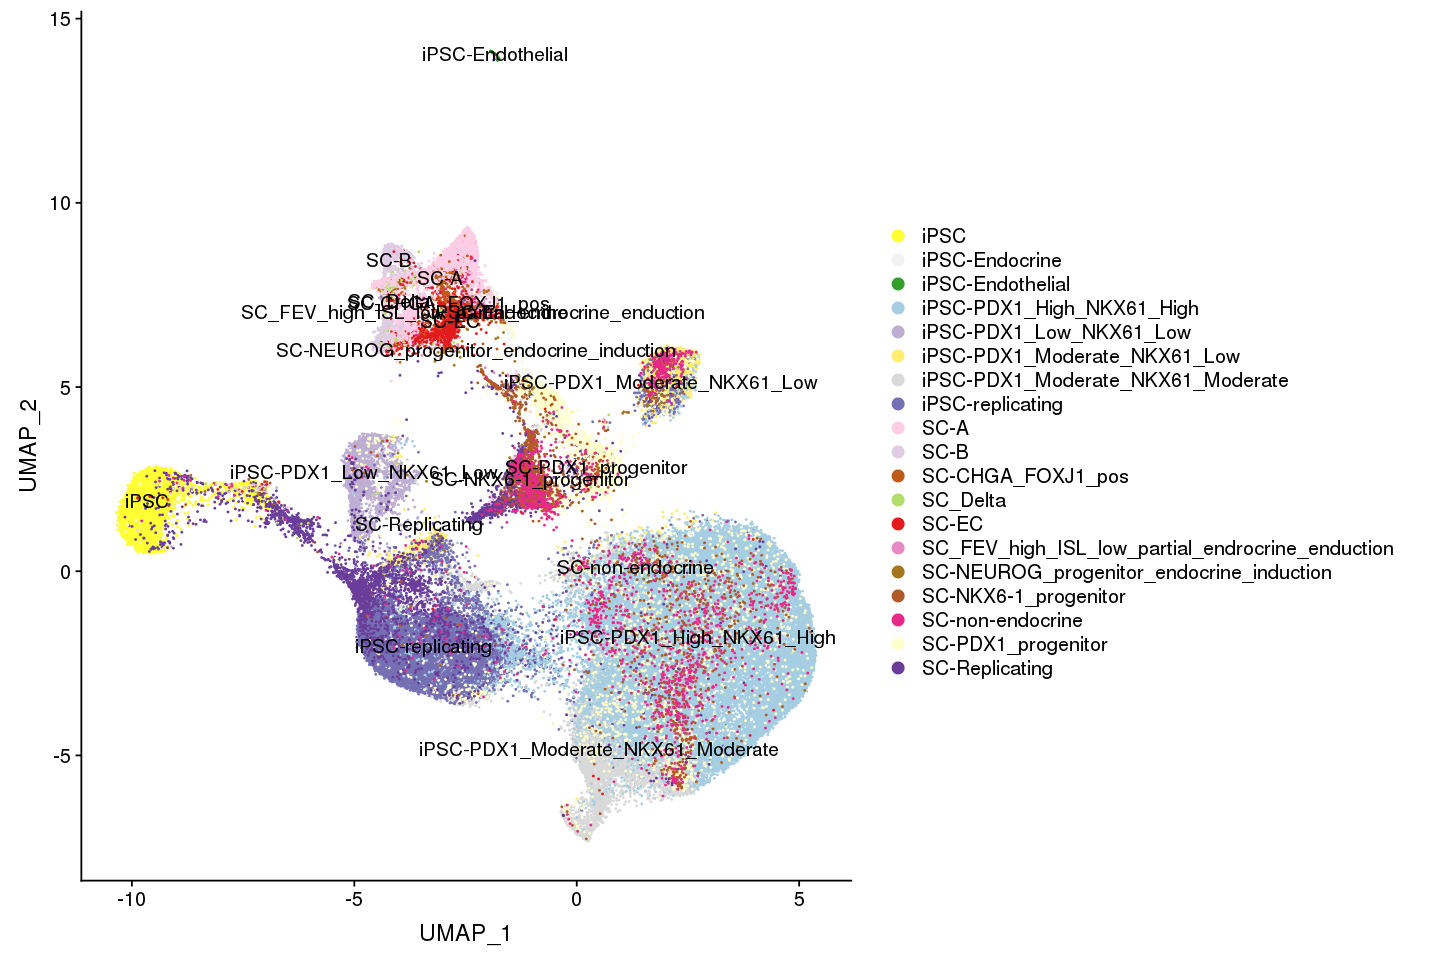

In [228]:
options(repr.plot.width = 12, repr.plot.height = 8)
DimPlot(integrated, group.by = "Celltype_new2plot", label = T, pt.size = .15, cols = sample(col_vector, 19))

In [210]:
save(integrated, file = "../data/frazer.cc.ff_melton.cc.ff_integrated_scaleF.robj")

# Try #3: Frazer + melton -> adjust after integration

In [24]:
f = "/projects/PPC/analysis/ppc_pilot/data/robjs/Frazermerged_new_seurat_SCBintegrated.robj"
sample_name = tools::file_path_sans_ext(basename(f))
load(f)

In [25]:
tiss = integrated

In [26]:
integrated = NULL

In [27]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes

In [28]:
tiss <- CellCycleScoring(tiss, s.features = s.genes, g2m.features = g2m.genes, set.ident = FALSE)

In [29]:
markers_ff = read.table("../Table/ff.degenes4correction.txt")
ff_de_genes = rownames(markers_ff)

In [132]:
# options(repr.plot.width = 15, repr.plot.height = 8)
# DimPlot(tiss, group.by = "Phase", label = T, pt.size = .15) + ylim(c(-10, 10))
# DimPlot(tiss, group.by = "Celltype", label = T, pt.size = .15) + ylim(c(-10, 10))
# # DimPlot(tiss, group.by = "new_celltype", label = T, pt.size = .15) + ylim(c(-10, 10))

In [119]:
# integrated data does not populated the 'counts' slot, so this is modified line from function PercentageFeatureSet to use RNA slot
# integrated data also populations 2 slots: 1) RNA, which is unnormalized and should be used for comparing gene expression/finding marker genes; 2) integrated, which should be used for visualization

percent.featureset <- colSums(as.matrix(GetAssayData(object = tiss, slot = "data")[features2use, ])) / tiss[[paste0("nCount_", "RNA")]] * 100

In [126]:
tiss@meta.data$percent.ff <- percent.featureset[,1]

In [130]:
tiss <- ScaleData(tiss, vars.to.regress = c("S.Score", "G2M.Score", "percent.ff"))
tiss <- RunPCA(tiss, npcs = 30, verbose = FALSE)
ElbowPlot(tiss, ndims = 30)
tiss <- RunUMAP(tiss, reduction = "pca", dims = 1:20)

In [145]:
tiss@meta.data$Celltype_new = tiss@meta.data$Celltype
tiss@meta.data[tiss@meta.data$Celltype == 0,]$Celltype_new = "iPSC-PDX1_High_NKX61_High"
tiss@meta.data[tiss@meta.data$Celltype == 1,]$Celltype_new = "iPSC-PDX1_High_NKX61_High"
tiss@meta.data[tiss@meta.data$Celltype == 2,]$Celltype_new = "iPSC-PDX1_High_NKX61_High"
tiss@meta.data[tiss@meta.data$Celltype == 3,]$Celltype_new = "iPSC-replicating"
tiss@meta.data[tiss@meta.data$Celltype == 4,]$Celltype_new = "iPSC"
tiss@meta.data[tiss@meta.data$Celltype == 5,]$Celltype_new = "iPSC-PDX1_High_NKX61_High"
tiss@meta.data[tiss@meta.data$Celltype == 6,]$Celltype_new  = "iPSC-PDX1_Moderate_NKX61_Moderate"
tiss@meta.data[tiss@meta.data$Celltype == 7,]$Celltype_new  = "iPSC-PDX1_Moderate_NKX61_Low"
tiss@meta.data[tiss@meta.data$Celltype == 8,]$Celltype_new  = "iPSC-PDX1_Low_NKX61_Low"
tiss@meta.data[tiss@meta.data$Celltype == 9,]$Celltype_new = "iPSC-replicating"
tiss@meta.data[tiss@meta.data$Celltype == 10,]$Celltype_new = "iPSC-PDX1_Moderate_NKX61_Moderate"
tiss@meta.data[tiss@meta.data$Celltype == 11,]$Celltype_new = "iPSC-PDX1_Moderate_NKX61_Moderate"
tiss@meta.data[tiss@meta.data$Celltype == 12,]$Celltype_new = "iPSC-PDX1_High_NKX61_High"
tiss@meta.data[tiss@meta.data$Celltype == 13,]$Celltype_new = "iPSC-Endocrine"
tiss@meta.data[tiss@meta.data$Celltype == 14,]$Celltype_new = "iPSC-PDX1_Low_NKX61_Low"
tiss@meta.data[tiss@meta.data$Celltype == 15,]$Celltype_new = "iPSC"
tiss@meta.data[tiss@meta.data$Celltype == 16,]$Celltype_new = "iPSC-Endothelial"

tiss@meta.data[tiss@meta.data$Celltype == "repl",]$Celltype_new             = "SC-Replicating"
tiss@meta.data[tiss@meta.data$Celltype == "pdx1",]$Celltype_new             = "SC-PDX1_progenitor"
tiss@meta.data[tiss@meta.data$Celltype == "nkx61",]$Celltype_new            = "SC-NKX6-1_progenitor"
tiss@meta.data[tiss@meta.data$Celltype == "sc_alpha",]$Celltype_new         = "SC-A"
tiss@meta.data[tiss@meta.data$Celltype == "fev_high_isl_neg",]$Celltype_new = "SC_FEV_high_ISL_low_partial_endrocrine_enduction"
tiss@meta.data[tiss@meta.data$Celltype == "neurog3",]$Celltype_new          = "SC-NEUROG_progenitor_endocrine_induction"
tiss@meta.data[tiss@meta.data$Celltype == "sst_hhex",]$Celltype_new         = "SC_Delta"
tiss@meta.data[tiss@meta.data$Celltype == "exo",]$Celltype_new              = "SC-non-endocrine"
tiss@meta.data[tiss@meta.data$Celltype == "sc_beta",]$Celltype_new          = "SC-B"
tiss@meta.data[tiss@meta.data$Celltype == "sc_ec",]$Celltype_new            = "SC-EC"
tiss@meta.data[tiss@meta.data$Celltype == "foxj1",]$Celltype_new            = "SC-CHGA_FOXJ1_pos"

In [222]:
library(RColorBrewer)
n <- 19
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

In [156]:
tiss <- FindNeighbors(tiss, dims = 1:20)
tiss <- FindClusters(tiss, resolution = 0.25)

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 108766
Number of edges: 2815653

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9168
Number of communities: 12
Elapsed time: 93 seconds


Warning message:
“Removed 374 rows containing missing values (geom_point).”

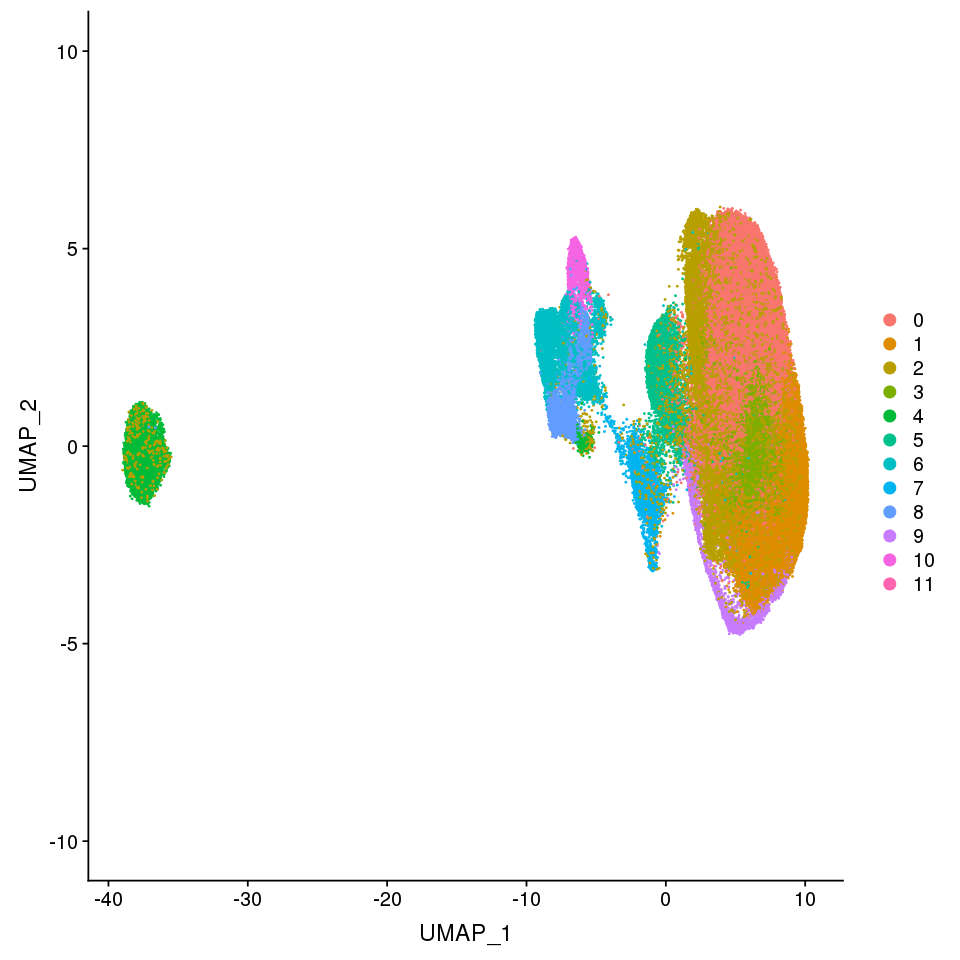

In [160]:
options(repr.plot.width = 8, repr.plot.height = 8)
DimPlot(tiss, group.by = "integrated_snn_res.0.25", label = F, pt.size = .15) + ylim(c(-10, 10))

Warning message:
“Removed 374 rows containing missing values (geom_point).”

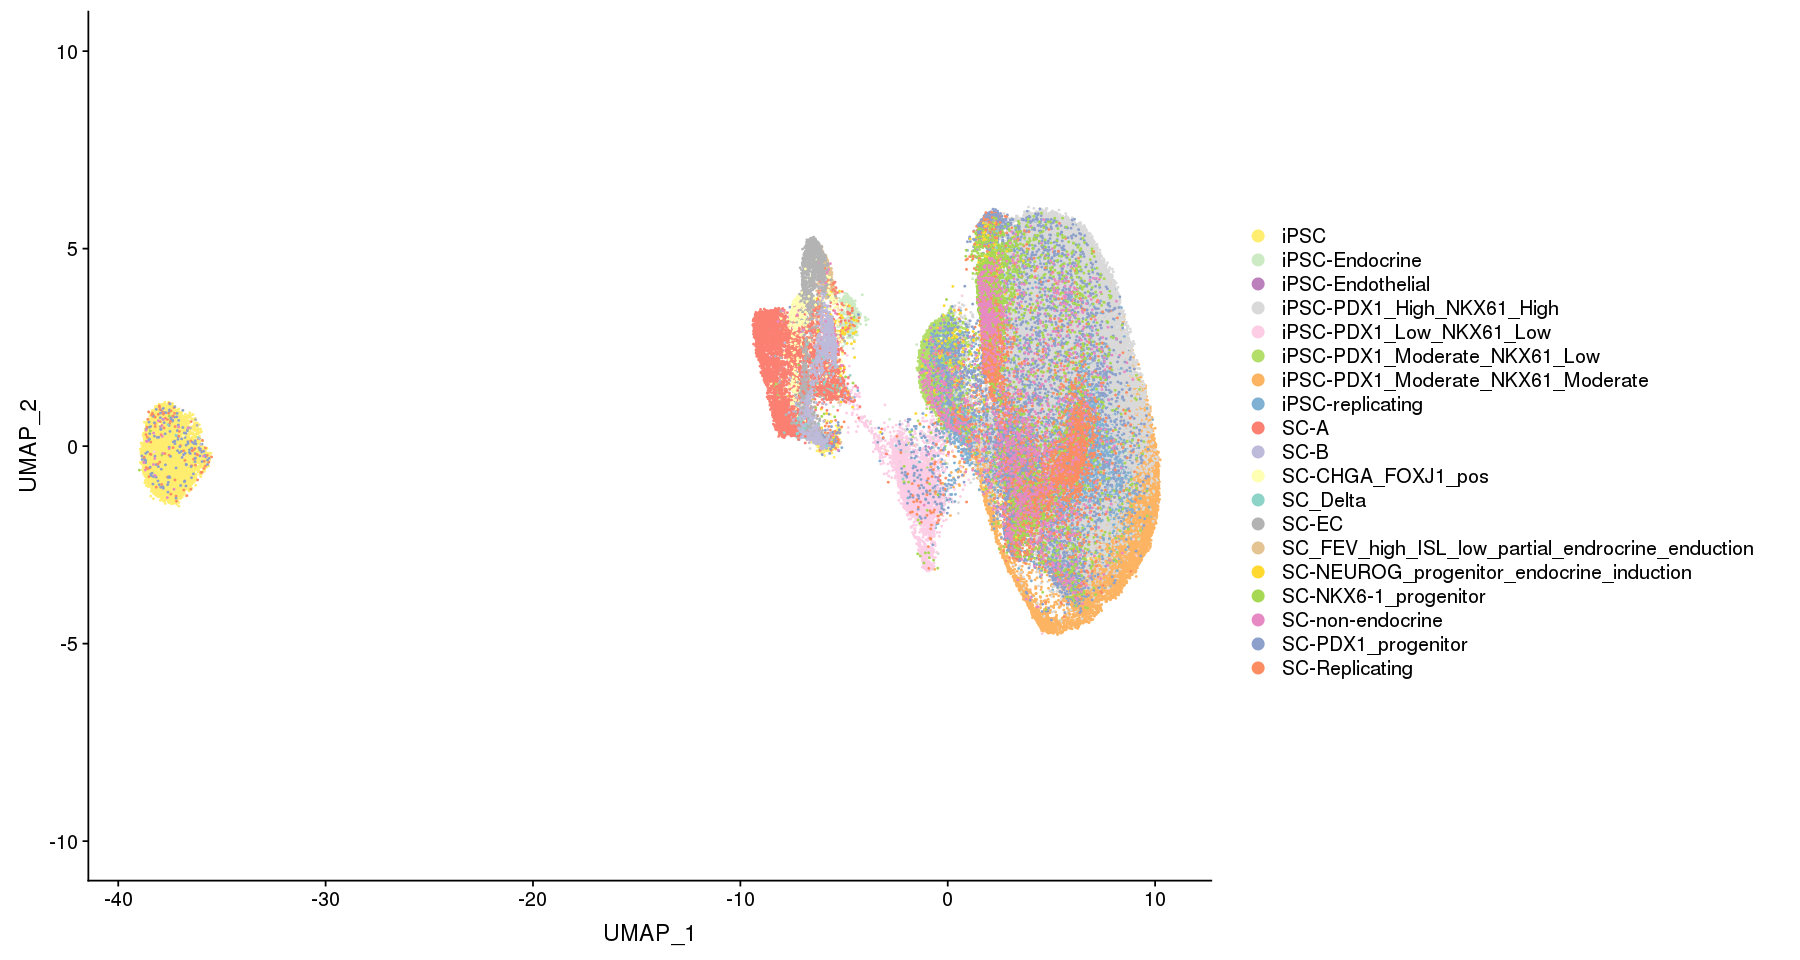

In [154]:
options(repr.plot.width = 15, repr.plot.height = 8)

DimPlot(tiss, group.by = "Celltype_new", label = F, pt.size = .15, cols = rev(col_vector)) + ylim(c(-10, 10))

Warning message:
“Removed 374 rows containing missing values (geom_point).”

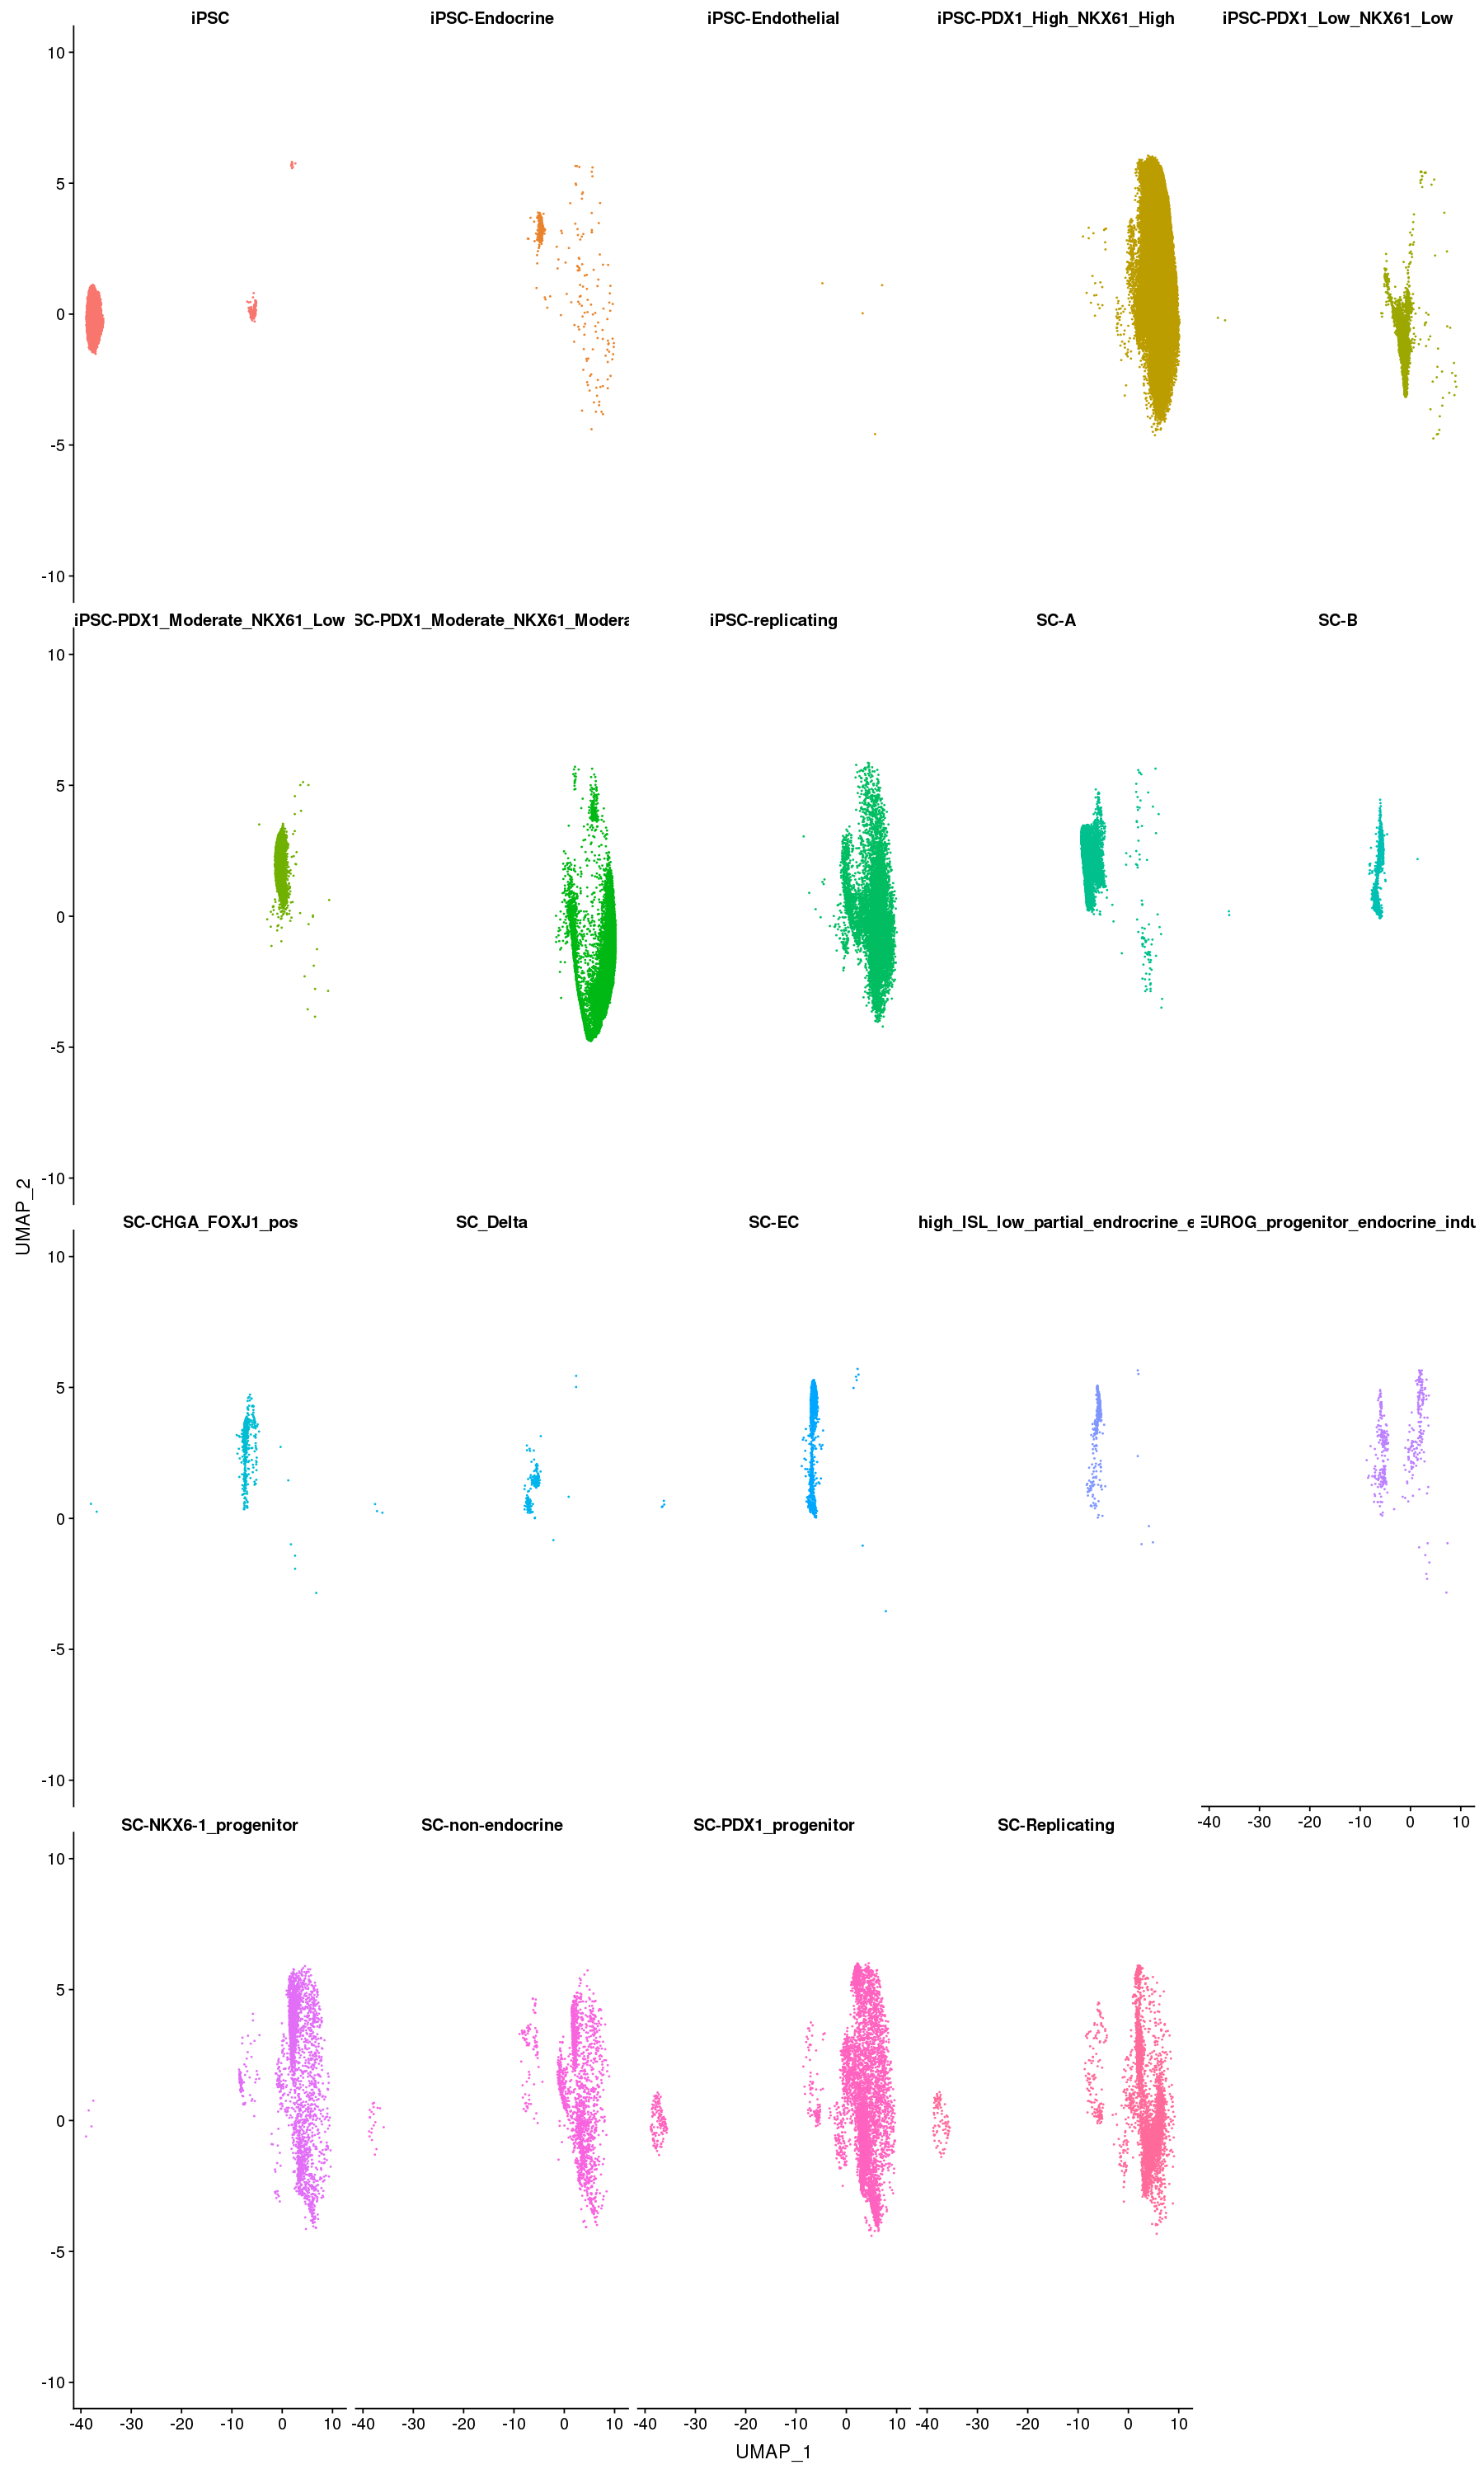

In [148]:
options(repr.plot.width = 15, repr.plot.height = 25)
DimPlot(tiss, split.by = "Celltype_new", group.by = "Celltype_new", label = F, pt.size = .15, ncol = 5) + ylim(c(-10, 10)) + NoLegend()
# DimPlot(tiss, group.by = "new_celltype", label = T, pt.size = .15) + ylim(c(-10, 10))

In [ ]:
save(tiss, file = "../data/frazer_melton_integrated_.cc.ff.adjusted.after_noRef.robj")